# Cryptocurrency Time Series Forecasting
## I want to forecast cryptocurrency exchange rates

# I will access the coinbase API in order to collect cryptocurrency historical data

In [1]:
import os
import time
import torch
import pickle
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from pathlib import Path
from arch import arch_model
import torch.optim as optim
import indicator.base as ib
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import torch.nn.functional as F
from tqdm.notebook import trange
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from coinbase.rest import RESTClient
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
sns.set()

In [3]:
def retrieve_ticker_minute_data(ticker: str, start_date: str, end_date: str):
    client = RESTClient(key_file="./coinbase_cloud_api_key2.json")
    time_delta = 18000
    start = int(pd.Timestamp(start_date).timestamp()) + 3600 * 4
    end_time = int(pd.Timestamp(end_date).timestamp()) + 3600 * 4
    df_list = []
    while start < end_time:
        end = min(start + time_delta, end_time)
        start_str = str(start)
        end_str = str(end)
        df_chunk = pd.DataFrame(client.get_candles(product_id=ticker, start=start_str, end=end_str, granularity='ONE_MINUTE'))
        df_list.append(df_chunk)
        start = end

    df = pd.concat(df_list, axis=0)
    return df

In [4]:
ticker = 'BTC-USDT'
start_date = '2024-04-14'
end_date = '2024-05-14'

In [5]:
unprocessed_df = retrieve_ticker_minute_data(ticker=ticker, start_date=start_date, end_date=end_date)
unprocessed_df

candles
0    {'start': '1713085200', 'low': '64549.58', 'hi...
1    {'start': '1713085140', 'low': '64504.26', 'hi...
2    {'start': '1713085080', 'low': '64483.6', 'hig...
3    {'start': '1713085020', 'low': '64466.82', 'hi...
4    {'start': '1713084960', 'low': '64529.4', 'hig...
..                                                 ...
286  {'start': '1715641440', 'low': '62761.66', 'hi...
287  {'start': '1715641380', 'low': '62717.69', 'hi...
288  {'start': '1715641320', 'low': '62715.27', 'hi...
289  {'start': '1715641260', 'low': '62749.67', 'hi...
290  {'start': '1715641200', 'low': '62757.82', 'hi...

[34220 rows x 1 columns]

# Data comes in JSON format and needs to be formatted

In [6]:
def format_data(data: pd.DataFrame):
    df = data.copy()
    df['Time_Stamp'] = df['candles'].apply(lambda x: datetime.fromtimestamp(int(x['start'])))
    df['Low'] = df['candles'].apply(lambda x: np.float64(x['low']))
    df['High'] = df['candles'].apply(lambda x: np.float64(x['high']))
    df['Open'] = df['candles'].apply(lambda x: np.float64(x['open']))
    df['Close'] = df['candles'].apply(lambda x: np.float64(x['close']))
    df['Volume'] = df['candles'].apply(lambda x: np.float64(x['volume']))
    df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])
    df.reset_index(inplace=True, drop=True)
    df = df[['Time_Stamp', 'Open', 'High', 'Close', 'Low', 'Volume']].set_index('Time_Stamp').sort_index()
    return df

In [7]:
formatted_df = format_data(data=unprocessed_df)
formatted_df

Open      High     Close       Low    Volume
Time_Stamp                                                           
2024-04-14 00:00:00  63431.95  63454.88  63454.88  63392.30  1.539006
2024-04-14 00:01:00  63464.84  63536.70  63503.91  63464.32  1.159321
2024-04-14 00:02:00  63505.65  63552.03  63552.03  63505.65  0.353188
2024-04-14 00:03:00  63580.89  63580.89  63443.49  63443.49  0.183753
2024-04-14 00:04:00  63454.60  63454.60  63453.73  63453.73  0.078755
...                       ...       ...       ...       ...       ...
2024-05-13 23:56:00  62422.40  62489.42  62471.95  62408.41  0.583796
2024-05-13 23:57:00  62464.17  62489.41  62473.58  62451.52  0.072413
2024-05-13 23:58:00  62473.59  62485.49  62459.29  62459.29  0.572646
2024-05-13 23:59:00  62452.52  62467.50  62452.45  62452.45  0.051732
2024-05-14 00:00:00  62446.94  62472.92  62458.80  62406.06  0.149110

[34220 rows x 5 columns]

In [8]:
formatted_df.isna().sum()

Open      0
High      0
Close     0
Low       0
Volume    0
dtype: int64

In [9]:
formatted_df.index.duplicated().sum()

121

# There is no na values, but there are duplicates that need to be removed and missing data that needs to be interpolated.

In [10]:
def remove_duplicates(data: pd.DataFrame):
    df = data.copy()
    df.reset_index(inplace=True)
    df = df.drop_duplicates(subset=['Time_Stamp'], keep='last')
    df.reset_index(inplace=True, drop=True)
    df.set_index('Time_Stamp', inplace=True)
    return df

In [11]:
deduped_df = remove_duplicates(data=formatted_df)
deduped_df

Open      High     Close       Low    Volume
Time_Stamp                                                           
2024-04-14 00:00:00  63431.95  63454.88  63454.88  63392.30  1.539006
2024-04-14 00:01:00  63464.84  63536.70  63503.91  63464.32  1.159321
2024-04-14 00:02:00  63505.65  63552.03  63552.03  63505.65  0.353188
2024-04-14 00:03:00  63580.89  63580.89  63443.49  63443.49  0.183753
2024-04-14 00:04:00  63454.60  63454.60  63453.73  63453.73  0.078755
...                       ...       ...       ...       ...       ...
2024-05-13 23:56:00  62422.40  62489.42  62471.95  62408.41  0.583796
2024-05-13 23:57:00  62464.17  62489.41  62473.58  62451.52  0.072413
2024-05-13 23:58:00  62473.59  62485.49  62459.29  62459.29  0.572646
2024-05-13 23:59:00  62452.52  62467.50  62452.45  62452.45  0.051732
2024-05-14 00:00:00  62446.94  62472.92  62458.80  62406.06  0.149110

[34099 rows x 5 columns]

In [12]:
deduped_df.index.duplicated().sum()

0

In [13]:
pd.date_range(start=deduped_df.index.min(), end=deduped_df.index.max(), freq='1min').difference(deduped_df.index).size

9102

# I will fill in the missing rows as follows:
## The missing open will be replaced with the previous close
## The missing close will be replaced with the future open
## The missing high will be replaced with the average of the previous and future high
## The missing low will be replaced with the average of the previous and future low
## The missing volume will be replaced with the average of the previous and future volume

In [14]:
def fill_in_missing_rows(data: pd.DataFrame):
    df = data.copy()
    fail_counter = 0
    
    o = [i for i in df.columns if 'open' in i.lower()][0]
    h = [i for i in df.columns if 'high' in i.lower()][0]
    l = [i for i in df.columns if 'low' in i.lower()][0]
    c = [i for i in df.columns if 'close' in i.lower()][0]
    v = [i for i in df.columns if 'volume' in i.lower()][0]
    
    
    while True:
        if 'Time_Stamp' in df.columns:
            df.set_index('Time_Stamp', inplace=True)
        
        complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1min')
        df = df.reindex(complete_time_index)
        df[o] = df[c].ffill()
        df[h] = df[o].bfill()
        df[l] = df[h].combine_first((df[h].ffill() + df[h].bfill()) / 2)
        df[c] = df[l].combine_first((df[l].ffill() + df[l].bfill()) / 2)
        df[v] = df[v].combine_first((df[v].ffill() + df[v].bfill()) / 2)
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        df = df.reset_index().rename(columns={'index': 'Time_Stamp'})
        
        missing_minutes = pd.date_range(start=df['Time_Stamp'].min(), end=df['Time_Stamp'].max(), freq='1min').difference(df['Time_Stamp']).size
        if missing_minutes == 0:
            break
        else:
            fail_counter += 1
            if fail_counter > 3:
                raise ValueError('fill_in_missing_rows malfunctioning')

    df['Date'] = df['Time_Stamp'].apply(lambda time_stamp: time_stamp.strftime('%Y-%m-%d'))
    df['Time'] = df['Time_Stamp'].apply(lambda time_stamp: time_stamp.strftime('%H:%M:%S'))
    return df.set_index('Time_Stamp').sort_index()

In [15]:
df = fill_in_missing_rows(data=deduped_df)
df

Open      High     Close       Low    Volume  \
Time_Stamp                                                              
2024-04-14 00:00:00  63454.88  63454.88  63454.88  63454.88  1.539006   
2024-04-14 00:01:00  63503.91  63503.91  63503.91  63503.91  1.159321   
2024-04-14 00:02:00  63552.03  63552.03  63552.03  63552.03  0.353188   
2024-04-14 00:03:00  63443.49  63443.49  63443.49  63443.49  0.183753   
2024-04-14 00:04:00  63453.73  63453.73  63453.73  63453.73  0.078755   
...                       ...       ...       ...       ...       ...   
2024-05-13 23:56:00  62471.95  62471.95  62471.95  62471.95  0.583796   
2024-05-13 23:57:00  62473.58  62473.58  62473.58  62473.58  0.072413   
2024-05-13 23:58:00  62459.29  62459.29  62459.29  62459.29  0.572646   
2024-05-13 23:59:00  62452.45  62452.45  62452.45  62452.45  0.051732   
2024-05-14 00:00:00  62458.80  62458.80  62458.80  62458.80  0.149110   

                           Date      Time  
Time_Stamp                                 
2024-04-14 00:00:00  2024-04-14  00:00:00  
2024-04-14 00:01:00  2024-04-14  00:01:00  
2024-04-14 00:02:00  2024-04-14  00:02:00  
2024-04-14 00:03:00  2024-04-14  00:03:00  
2024-04-14 00:04:00  2024-04-14  00:04:00  
...                         ...       ...  
2024-05-13 23:56:00  2024-05-13  23:56:00  
2024-05-13 23:57:00  2024-05-13  23:57:00  
2024-05-13 23:58:00  2024-05-13  23:58:00  
2024-05-13 23:59:00  2024-05-13  23:59:00  
2024-05-14 00:00:00  2024-05-14  00:00:00  

[43201 rows x 7 columns]

In [16]:
pd.date_range(start=df.index.min(), end=df.index.max(), freq='1min').difference(df.index).size

0

# Now that that all missing rows have been interpolated and all of the duplicates have been removed, We can correctly analyze our data

In [17]:
df.describe()

Open          High         Close           Low        Volume
count  43201.000000  43201.000000  43201.000000  43201.000000  4.320100e+04
mean   63005.962324  63005.962324  63005.962324  63005.962324  4.364400e-01
std     2035.709761   2035.709761   2035.709761   2035.709761  1.005173e+00
min    56601.310000  56601.310000  56601.310000  56601.310000  1.000000e-07
25%    61705.170000  61705.170000  61705.170000  61705.170000  6.764950e-02
50%    63280.470000  63280.470000  63280.470000  63280.470000  1.613665e-01
75%    64209.710000  64209.710000  64209.710000  64209.710000  4.427234e-01
max    67221.490000  67221.490000  67221.490000  67221.490000  6.229108e+01

# The standard deviation of the volume is very close to the mean implying heavy volatility, which is natural for BTC-USDT

# Now I will add different time frames in order to be able to analyze the data from multiple perspectives

In [18]:
def create_time_frame(df: pd.DataFrame, time_frame: int):
    df[f'{time_frame}_Minute_cumsum'] = np.ones(df.shape[0], np.int64)
    df[f'{time_frame}_Minute_cumsum'] = df[f'{time_frame}_Minute_cumsum'].cumsum().values
    df[f'{time_frame}_Minute_Complete_Candle'] = np.zeros(df.shape[0], np.int64)
    df[f'{time_frame}_Minute_Complete_Candle'].where(~(df[f'{time_frame}_Minute_cumsum'].values % time_frame == 0), np.int64(1), inplace=True)
    df[f'{time_frame}_Minute_Candle_Counter'] = df[f'{time_frame}_Minute_Complete_Candle'].cumsum().shift().values
    df.loc[0, f'{time_frame}_Minute_Candle_Counter'] = np.int64(0)
    df[f'{time_frame}_Minute_Start_Time'] = df[[f'{time_frame}_Minute_Candle_Counter', 'Start_Time']].groupby(f'{time_frame}_Minute_Candle_Counter')['Start_Time'].transform('first')
    df[f'{time_frame}_Minute_Open'] = df[[f'{time_frame}_Minute_Candle_Counter', 'Open']].groupby(f'{time_frame}_Minute_Candle_Counter')['Open'].transform('first')
    df[f'{time_frame}_Minute_High'] = df.groupby(f'{time_frame}_Minute_Candle_Counter')['High'].cummax().values
    df[f'{time_frame}_Minute_Low'] = df.groupby(f'{time_frame}_Minute_Candle_Counter')['Low'].cummin().values
    df[f'{time_frame}_Minute_Close'] = df['Close']
    df[f'{time_frame}_Minute_Volume'] = df.groupby(f'{time_frame}_Minute_Candle_Counter')['Volume'].cumsum().values
    df.drop(f'{time_frame}_Minute_cumsum', axis=1, inplace=True)
    return df

def create_time_frames(data: pd.DataFrame, time_frames: list):
    df = data.copy()
    df = df[['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df['Start_Time'] = df.index
    for time_frame in time_frames:
        if time_frame == 1:
            continue
            
        df = create_time_frame(df=df, time_frame=time_frame)

    df.rename(
        columns={
            'Open': '1_Minute_Open',
            'High': '1_Minute_High',
            'Low': '1_Minute_Low',
            'Close': '1_Minute_Close', 
            'Volume': '1_Minute_Volume'
        }, inplace=True
    )

    df.drop('Start_Time', axis=1, inplace=True)
    df.drop(0, axis=0, inplace=True)
    return df.bfill()

In [19]:
time_frames = [1, 3, 5, 10, 15, 30, 60, 120, 180, 240, 300, 360, 420, 480, 1440, 2880, 4320, 5760, 7200, 8640, 10080, 11520, 12960]

In [20]:
df_time_frames = create_time_frames(data=df, time_frames=time_frames)
df_time_frames

C:\Users\Amram\AppData\Local\Temp\ipykernel_23736\2262265345.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f'{time_frame}_Minute_Complete_Candle'].where(~(df[f'{time_frame}_Minute_cumsum'].values % time_frame == 0), np.int64(1), inplace=True)
C:\Users\Amram\AppData\Local\Temp\ipykernel_23736\2262265345.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

Date      Time  1_Minute_Open  1_Minute_High  \
Time_Stamp                                                                
2024-04-14 00:00:00  2024-04-14  00:00:00       63454.88       63454.88   
2024-04-14 00:01:00  2024-04-14  00:01:00       63503.91       63503.91   
2024-04-14 00:02:00  2024-04-14  00:02:00       63552.03       63552.03   
2024-04-14 00:03:00  2024-04-14  00:03:00       63443.49       63443.49   
2024-04-14 00:04:00  2024-04-14  00:04:00       63453.73       63453.73   
...                         ...       ...            ...            ...   
2024-05-13 23:56:00  2024-05-13  23:56:00       62471.95       62471.95   
2024-05-13 23:57:00  2024-05-13  23:57:00       62473.58       62473.58   
2024-05-13 23:58:00  2024-05-13  23:58:00       62459.29       62459.29   
2024-05-13 23:59:00  2024-05-13  23:59:00       62452.45       62452.45   
2024-05-14 00:00:00  2024-05-14  00:00:00       62458.80       62458.80   

                     1_Minute_Low  1_Minute_Close  1_Minute_Volume  \
Time_Stamp                                                           
2024-04-14 00:00:00      63454.88        63454.88         1.539006   
2024-04-14 00:01:00      63503.91        63503.91         1.159321   
2024-04-14 00:02:00      63552.03        63552.03         0.353188   
2024-04-14 00:03:00      63443.49        63443.49         0.183753   
2024-04-14 00:04:00      63453.73        63453.73         0.078755   
...                           ...             ...              ...   
2024-05-13 23:56:00      62471.95        62471.95         0.583796   
2024-05-13 23:57:00      62473.58        62473.58         0.072413   
2024-05-13 23:58:00      62459.29        62459.29         0.572646   
2024-05-13 23:59:00      62452.45        62452.45         0.051732   
2024-05-14 00:00:00      62458.80        62458.80         0.149110   

                     3_Minute_Complete_Candle  3_Minute_Candle_Counter  \
Time_Stamp                                                               
2024-04-14 00:00:00                       0.0                      0.0   
2024-04-14 00:01:00                       0.0                      0.0   
2024-04-14 00:02:00                       1.0                      0.0   
2024-04-14 00:03:00                       0.0                      1.0   
2024-04-14 00:04:00                       0.0                      1.0   
...                                       ...                      ...   
2024-05-13 23:56:00                       1.0                  14398.0   
2024-05-13 23:57:00                       0.0                  14399.0   
2024-05-13 23:58:00                       0.0                  14399.0   
2024-05-13 23:59:00                       1.0                  14399.0   
2024-05-14 00:00:00                       0.0                  14400.0   

                    3_Minute_Start_Time  ...  11520_Minute_Close  \
Time_Stamp                               ...                       
2024-04-14 00:00:00 2024-04-14 00:01:00  ...            63454.88   
2024-04-14 00:01:00 2024-04-14 00:01:00  ...            63503.91   
2024-04-14 00:02:00 2024-04-14 00:01:00  ...            63552.03   
2024-04-14 00:03:00 2024-04-14 00:03:00  ...            63443.49   
2024-04-14 00:04:00 2024-04-14 00:03:00  ...            63453.73   
...                                 ...  ...                 ...   
2024-05-13 23:56:00 2024-05-13 23:54:00  ...            62471.95   
2024-05-13 23:57:00 2024-05-13 23:57:00  ...            62473.58   
2024-05-13 23:58:00 2024-05-13 23:57:00  ...            62459.29   
2024-05-13 23:59:00 2024-05-13 23:57:00  ...            62452.45   
2024-05-14 00:00:00 2024-05-14 00:00:00  ...            62458.80   

                     11520_Minute_Volume  12960_Minute_Complete_Candle  \
Time_Stamp                                                               
2024-04-14 00:00:00             1.159321                             0   
2024-04-14 00:01:00             1.159321                             0

In [21]:
df_time_frames[[i for i in df_time_frames.columns if 'complete' in i.lower()]].sum()

3_Minute_Complete_Candle        14400.0
5_Minute_Complete_Candle         8640.0
10_Minute_Complete_Candle        4320.0
15_Minute_Complete_Candle        2880.0
30_Minute_Complete_Candle        1440.0
60_Minute_Complete_Candle         720.0
120_Minute_Complete_Candle        360.0
180_Minute_Complete_Candle        240.0
240_Minute_Complete_Candle        180.0
300_Minute_Complete_Candle        144.0
360_Minute_Complete_Candle        120.0
420_Minute_Complete_Candle        102.0
480_Minute_Complete_Candle         90.0
1440_Minute_Complete_Candle        30.0
2880_Minute_Complete_Candle        15.0
4320_Minute_Complete_Candle        10.0
5760_Minute_Complete_Candle         7.0
7200_Minute_Complete_Candle         6.0
8640_Minute_Complete_Candle         5.0
10080_Minute_Complete_Candle        4.0
11520_Minute_Complete_Candle        3.0
12960_Minute_Complete_Candle        3.0
dtype: float64

# Now that I have multiple time frames, I will apply some feature engineering

# I will apply moving averages, confidence intervals, rates of change, and some more indicators from an indicator bank

In [22]:
def get_critical_value(confidence_interval):
    alpha = 1 - confidence_interval
    critical_value = stats.norm.ppf(1 - alpha / 2)
    return critical_value


def add_indicators(data: pd.DataFrame, time_frame: int = 1):
    df = data.copy()
    new_columns = {}
    for method_name in dir(ib):
        if method_name in ['REF', 'COUNT']:
            continue
        if method_name[0] != '_':
            try:
                method = getattr(ib, method_name)
                # IF method failed to function(['logic', 'a', 'b']) - IF() missing 1 required positional argument: 'b'
                # IFAND method failed to function(['logic1', 'logic2', 'a', 'b']) - IFAND() missing 2 required positional arguments: 'a' and 'b'
                # MEMA method failed to function(['series', 'n']) - window must be an integer 0 or greater
                try:
                    new_column = method(df[f'{time_frame}_Minute_Delta0'])
                except BaseException as e:
                    new_column = method(df[f'{time_frame}_Minute_Open'], df[f'{time_frame}_Minute_Close'])

                new_columns[method_name] = new_column
            except BaseException as e:
                pass

    for column_name, new_column in new_columns.items():
        df[f'{time_frame}_Minute_{column_name}'] = new_column.shift(1)

    return df
    

def create_statistical_features(data: pd.DataFrame, time_frames: list, confidence_intervals: list = [0.95], windows: list = [20], derivatives=2, s: int = 100):
    df = data.copy()
    for time_frame in time_frames:
        df[f'log_{time_frame}_Minute_Close'] = np.log(df[f'{time_frame}_Minute_Close']).diff(s).dropna()
        for window in windows:
    
            if f'{time_frame}_Minute_MA{window}' not in [*df.columns] or f'{time_frame}_Minute_STD{window}' not in [*df.columns]:
                price_sum = df[f'{time_frame}_Minute_Open'] + df[f'{time_frame}_Minute_Low'] + df[f'{time_frame}_Minute_High'] + df[f'{time_frame}_Minute_Close']
                df[f'{time_frame}_Minute_Delta0'] = price_sum / 4
                df[f'{time_frame}_Minute_MA{window}'] = df[f'{time_frame}_Minute_Delta0'].rolling(window=window).mean()
                df[f'{time_frame}_Minute_STD{window}'] = df[f'{time_frame}_Minute_Delta0'].rolling(window=window).std()

            for confidence_interval in confidence_intervals:
                if confidence_interval < 0 or confidence_interval > 1:
                    raise ValueError('Confidence Interval must be between 0 and 1')
                    
                critical_value = get_critical_value(confidence_interval=confidence_interval)
                df[f'{time_frame}_Minute_CI{str(int(confidence_interval * 100))}_U_{window}'] = df[f'{time_frame}_Minute_MA{window}'] + critical_value * df[f'{time_frame}_Minute_STD{window}']
                df[f'{time_frame}_Minute_CI{str(int(confidence_interval * 100))}_L_{window}'] = df[f'{time_frame}_Minute_MA{window}'] - critical_value * df[f'{time_frame}_Minute_STD{window}']               

        if derivatives:
            derivative_counter = 0
            for i in range(derivatives):
                derivative_counter += 1
                if derivative_counter == 1:
                    df[f'{time_frame}_Minute_Delta{derivative_counter}'] = df[f'{time_frame}_Minute_Delta0'].diff(1)
                else:
                    df[f'{time_frame}_Minute_Delta{derivative_counter}'] = df[f'{time_frame}_Minute_Delta{derivative_counter - 1}'].diff(1)

        df = add_indicators(data=df, time_frame=time_frame)

    return df

In [23]:
analyzed_df = create_statistical_features(data=df_time_frames, time_frames=time_frames)
analyzed_df

Date      Time  1_Minute_Open  1_Minute_High  \
Time_Stamp                                                                
2024-04-14 00:00:00  2024-04-14  00:00:00       63454.88       63454.88   
2024-04-14 00:01:00  2024-04-14  00:01:00       63503.91       63503.91   
2024-04-14 00:02:00  2024-04-14  00:02:00       63552.03       63552.03   
2024-04-14 00:03:00  2024-04-14  00:03:00       63443.49       63443.49   
2024-04-14 00:04:00  2024-04-14  00:04:00       63453.73       63453.73   
...                         ...       ...            ...            ...   
2024-05-13 23:56:00  2024-05-13  23:56:00       62471.95       62471.95   
2024-05-13 23:57:00  2024-05-13  23:57:00       62473.58       62473.58   
2024-05-13 23:58:00  2024-05-13  23:58:00       62459.29       62459.29   
2024-05-13 23:59:00  2024-05-13  23:59:00       62452.45       62452.45   
2024-05-14 00:00:00  2024-05-14  00:00:00       62458.80       62458.80   

                     1_Minute_Low  1_Minute_Close  1_Minute_Volume  \
Time_Stamp                                                           
2024-04-14 00:00:00      63454.88        63454.88         1.539006   
2024-04-14 00:01:00      63503.91        63503.91         1.159321   
2024-04-14 00:02:00      63552.03        63552.03         0.353188   
2024-04-14 00:03:00      63443.49        63443.49         0.183753   
2024-04-14 00:04:00      63453.73        63453.73         0.078755   
...                           ...             ...              ...   
2024-05-13 23:56:00      62471.95        62471.95         0.583796   
2024-05-13 23:57:00      62473.58        62473.58         0.072413   
2024-05-13 23:58:00      62459.29        62459.29         0.572646   
2024-05-13 23:59:00      62452.45        62452.45         0.051732   
2024-05-14 00:00:00      62458.80        62458.80         0.149110   

                     3_Minute_Complete_Candle  3_Minute_Candle_Counter  \
Time_Stamp                                                               
2024-04-14 00:00:00                       0.0                      0.0   
2024-04-14 00:01:00                       0.0                      0.0   
2024-04-14 00:02:00                       1.0                      0.0   
2024-04-14 00:03:00                       0.0                      1.0   
2024-04-14 00:04:00                       0.0                      1.0   
...                                       ...                      ...   
2024-05-13 23:56:00                       1.0                  14398.0   
2024-05-13 23:57:00                       0.0                  14399.0   
2024-05-13 23:58:00                       0.0                  14399.0   
2024-05-13 23:59:00                       1.0                  14399.0   
2024-05-14 00:00:00                       0.0                  14400.0   

                    3_Minute_Start_Time  ...  12960_Minute_CROSS  \
Time_Stamp                               ...                       
2024-04-14 00:00:00 2024-04-14 00:01:00  ...                 NaN   
2024-04-14 00:01:00 2024-04-14 00:01:00  ...                 0.0   
2024-04-14 00:02:00 2024-04-14 00:01:00  ...                 0.0   
2024-04-14 00:03:00 2024-04-14 00:03:00  ...                 0.0   
2024-04-14 00:04:00 2024-04-14 00:03:00  ...                 1.0   
...                                 ...  ...                 ...   
2024-05-13 23:56:00 2024-05-13 23:54:00  ...                 0.0   
2024-05-13 23:57:00 2024-05-13 23:57:00  ...                 0.0   
2024-05-13 23:58:00 2024-05-13 23:57:00  ...                 0.0   
2024-05-13 23:59:00 2024-05-13 23:57:00  ...                 0.0   
2024-05-14 00:00:00 2024-05-14 00:00:00  ...                 0.0   

                     12960_Minute_EMA  12960_Minute_HHV  12960_Minute_LLV  \
Time_Stamp                                                                  
2024-04-14 00:00:00               NaN               NaN               NaN   
2024-04-14 00:01:00      63491.652500               NaN      

In [24]:
analyzed_df.columns

Index(['Date', 'Time', '1_Minute_Open', '1_Minute_High', '1_Minute_Low',
       '1_Minute_Close', '1_Minute_Volume', '3_Minute_Complete_Candle',
       '3_Minute_Candle_Counter', '3_Minute_Start_Time',
       ...
       '12960_Minute_CROSS', '12960_Minute_EMA', '12960_Minute_HHV',
       '12960_Minute_LLV', '12960_Minute_MA', '12960_Minute_MAX',
       '12960_Minute_MIN', '12960_Minute_SMA', '12960_Minute_STD',
       '12960_Minute_SUM'],
      dtype='object', length=643)

# Now to visualize the data to get a better understanding of it

In [25]:
def candlesticks_viz(df: pd.DataFrame, time_frame: int = 1, confidence_interval: float = 0.95, window: int = 20):
    data = df.copy()
    
    if 'Time_Stamp' not in data.columns:
        data.reset_index(inplace=True)

    if 'index' in data.columns:
        data.drop('index', axis=1, inplace=True)

    relevant_columns = ['Time_Stamp', 'Date', 'Time']
    relevant_columns.extend([col for col in data.columns if str(time_frame) in col])            
    relevant_columns = [col for col in relevant_columns if col in data.columns]    
    data = data[relevant_columns]
    data = data.loc[data[f'{time_frame}_Minute_Complete_Candle'] == 1, :]
    data.reset_index(inplace=True, drop=True)
    data.sort_values('Time_Stamp', inplace=True)
    data = data.tail(1000)
        
    # Create a subplot figure with 2 rows and shared x-axis
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3]
    )

    # Add candlestick trace
    fig.add_trace(go.Candlestick(
        x=data['Time_Stamp'],
        open=data[f'{time_frame}_Minute_Open'],
        high=data[f'{time_frame}_Minute_High'],
        low=data[f'{time_frame}_Minute_Low'],
        close=data[f'{time_frame}_Minute_Close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        name='Candlesticks'
    ), row=1, col=1)

    # Confidence Interval
    upper_band = f'{time_frame}_Minute_CI{int(confidence_interval * 100)}_U_{window}'
    lower_band = f'{time_frame}_Minute_CI{int(confidence_interval * 100)}_L_{window}'

    if upper_band in data.columns:
        fig.add_trace(go.Scatter(
            x=data['Time_Stamp'],
            y=data[upper_band],
            mode='lines',
            line=dict(color='purple', width=2),
            name=upper_band
        ), row=1, col=1)

    if lower_band in data.columns:
        fig.add_trace(go.Scatter(
            x=data['Time_Stamp'],
            y=data[lower_band],
            mode='lines',
            line=dict(color='purple', width=2),
            name=lower_band
        ), row=1, col=1)
    
    # Add volume bars in the second row
    fig.add_trace(go.Bar(
        x=data['Time_Stamp'],
        y=data[f'{time_frame}_Minute_Volume'],
        name='Volume',
        marker=dict(
            color=['green' if open_ < close_ else 'red' for open_, close_ in zip(data[f'{time_frame}_Minute_Open'], data[f'{time_frame}_Minute_Close'])],
            line=dict(width=0)  # Remove borders for a cleaner look
        ),
        showlegend=False
    ), row=2, col=1)

    # Update layout for the figure
    fig.update_layout(
        title=f'{time_frame} Minute Candlestick Chart with Volume',
        xaxis=dict(rangeslider=dict(visible=False)),
        xaxis2=dict(title='Time'),
        yaxis=dict(title='Price'),
        yaxis2=dict(title='Volume'),
        hovermode='x unified',
        legend=dict(x=0.01, y=0.99),
        margin=dict(l=40, r=40, t=40, b=40)
    )

    # Customize hover labels for both traces
    fig.update_traces(hoverinfo='x+y+text')

    # Show the figure
    fig.show()

    if 'Time_Stamp' in df.columns:
        df.set_index('Time_Stamp', inplace=True)
        df.sort_index(inplace=True)

    if 'index' in df.columns:
        df.drop('index', axis=1, inplace=True)

In [26]:
def dydx_viz(data: pd.DataFrame, time_frame: int = 1, derivatives: int = 2):
    df = data.copy()
    
    # Create subplots
    df['Numeric_Date'] = df.index.values
    df['Numeric_Date'] = pd.to_numeric(df['Numeric_Date'])
    average_deltas = {0: df[f'{time_frame}_Minute_Delta0'].mean()}
    for derivative in range(1, derivatives + 1):
        average_deltas[derivative] = df[f'{time_frame}_Minute_Delta{derivative}'].mean()

    dydx_colors = [plt.get_cmap('rainbow')(i / 6) for i in range(7)]
    axes = []
    fig, ax = plt.subplots()
    ax.scatter(df['Numeric_Date'], df[f'{time_frame}_Minute_Delta0'], color=dydx_colors.pop(0), label='Delta0', s=10, alpha=0.2)
    axes.append(ax)
    
    ax_position = 0
    for derivative in range(2, derivatives + 2):
        exec(f"ax{derivative - 1} = ax.twinx()")
        exec(f"ax{derivative - 1}.spines['right'].set_position(('outward', {ax_position}))")
        exec(f"ax{derivative - 1}.scatter(df['Numeric_Date'], df[f'{time_frame}_Minute_Delta{derivative - 1}'], color=dydx_colors.pop(0), label=f'Delta{derivative}', s=10)")
        exec(f"axes.append(ax{derivative - 1})")
        ax_position += 60

    # Add best-fit lines
    for col, axis, color in zip([i for i in df.columns if 'delta' in i.lower()], axes, dydx_colors):
        x = df['Numeric_Date'].values.reshape(-1, 1)
        y = df[col].fillna(0).values.reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        axis.plot(df['Numeric_Date'], y_pred, linestyle='--', color=color)

    # Set y-axis limits for each subplot
    counter = -1
    for axis in axes:
        counter += 1
        axis.set_ylim(df[f'{time_frame}_Minute_Delta{counter}'].min(), df[f'{time_frame}_Minute_Delta{counter}'].max())
        axis.set_ylabel(f'{time_frame}_Minute_Delta{counter}', color=dydx_colors[counter])
        axis.legend(loc='best')

    # Set labels and legend
    ax.set_xlabel('Time_Stamp')
    ax.set_title(f'{time_frame}_Minute_Deltas')

    # Show the plot
    plt.show()

In [27]:
def polynomial_surface(X, a, b, c, d, e, f):
    x, y = X
    return a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

def fit_surface(time_indices, prices, volatilities):
    xdata = np.vstack((time_indices, prices))
    zdata = volatilities
    popt, _ = curve_fit(polynomial_surface, xdata, zdata)
    a, b, c, d, e, f = popt
    print(f'historical_volatilities = {a}*time**2 + {b}*prices**2 + {c}*time*y + {d}*time + {e}*prices + {f}')
    return popt

def create_surface(X, Y, popt):
    Z = polynomial_surface((X, Y), *popt)
    return Z

def volatility_viz(data: pd.DataFrame, time_frame: int = 1, window: int = 30, observations: int = 100):
    df = data.copy()
    df[f'{time_frame}_Minute_Returns'] = df[f'{time_frame}_Minute_Close'].pct_change()
    df[f'{time_frame}_Minute_Volatility'] = df[f'{time_frame}_Minute_Returns'].rolling(window=window).std()
    df.dropna(inplace=True)
    df = df.tail(observations)
    
    # Create the 3D plot data
    time_indices = np.arange(observations)
    prices = df[f'{time_frame}_Minute_Close'].values
    volatilities = df[f'{time_frame}_Minute_Volatility'].values

    time_indices = np.nan_to_num(time_indices, nan=0.0, posinf=0.0, neginf=0.0)
    prices = np.nan_to_num(prices, nan=0.0, posinf=0.0, neginf=0.0)
    volatilities = np.nan_to_num(volatilities, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Fit a polynomial surface to the data
    popt = fit_surface(time_indices, prices, volatilities)

    # Create a meshgrid for the 3D plot
    X, Y = np.meshgrid(np.linspace(time_indices.min(), time_indices.max(), observations), 
                       np.linspace(prices.min(), prices.max(), observations))

    # Create the fitted surface
    Z_surface = create_surface(X, Y, popt)

    # Create scatter plot
    scatter_plot = go.Scatter3d(
        x=time_indices,
        y=prices,
        z=volatilities,
        mode='markers',
        marker=dict(
            size=5,
            color=volatilities,
            colorscale='Viridis',
            opacity=0.8
        )
    )

    # Create surface plot
    surface_plot = go.Surface(
        x=X,
        y=Y,
        z=Z_surface,
        colorscale='Viridis',
        opacity=0.5
    )

    # Create layout for the plots
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='Time Index'),
            yaxis=dict(title='Price Level'),
            zaxis=dict(title=f'{time_frame} Minute Volatility')
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    # Create figure and add scatter and surface plot data
    # fig = go.Figure(data=[scatter_plot, surface_plot], layout=layout)
    fig = go.Figure(data=[scatter_plot], layout=layout)

    # Show the plot
    fig.show()

In [28]:
time_frame = 60

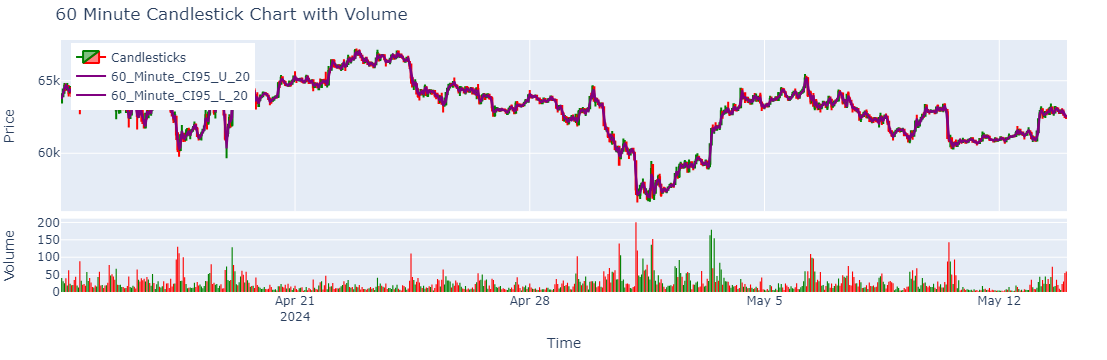

In [29]:
candlesticks_viz(df=analyzed_df, time_frame=time_frame, confidence_interval=0.95, window=20)

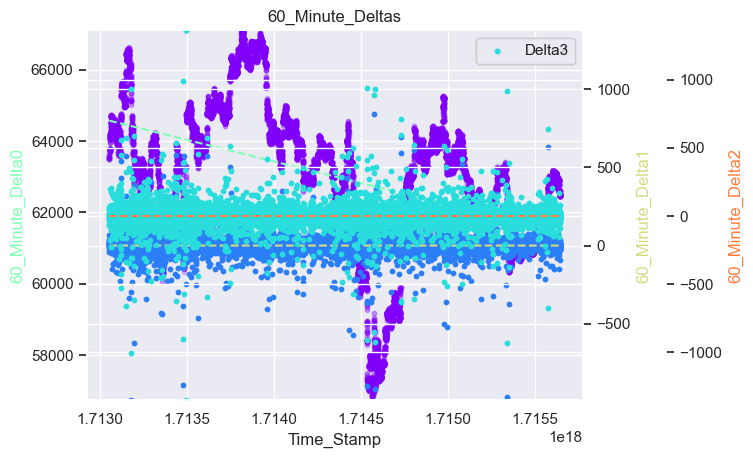

In [30]:
dydx_viz(data=analyzed_df, time_frame=time_frame, derivatives=2)

historical_volatilities = -9.773878689697567e-08*time**2 + -7.79217163210691e-09*prices**2 + -4.251331278407852e-08*time*y + 0.0026683001792871656*time + 0.0009768571754482083*prices + -30.615062751601897


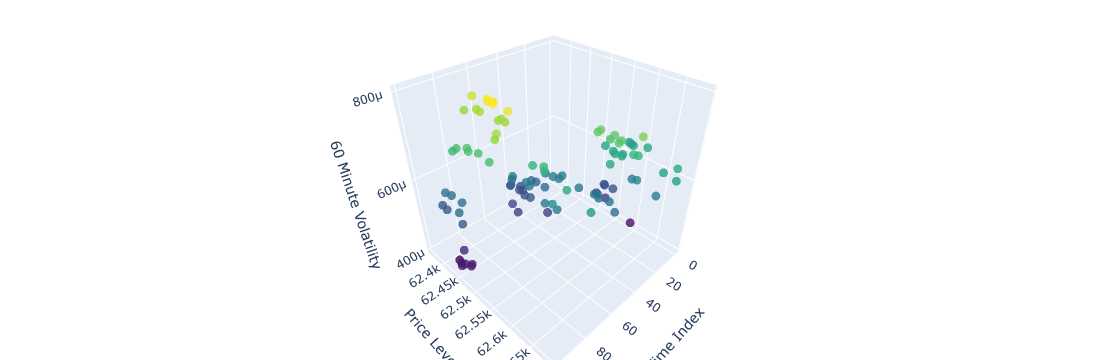

In [31]:
volatility_viz(data=analyzed_df, time_frame=time_frame, window=20)

In [32]:
analyzed_df

Date      Time  1_Minute_Open  1_Minute_High  \
Time_Stamp                                                                
2024-04-14 00:00:00  2024-04-14  00:00:00       63454.88       63454.88   
2024-04-14 00:01:00  2024-04-14  00:01:00       63503.91       63503.91   
2024-04-14 00:02:00  2024-04-14  00:02:00       63552.03       63552.03   
2024-04-14 00:03:00  2024-04-14  00:03:00       63443.49       63443.49   
2024-04-14 00:04:00  2024-04-14  00:04:00       63453.73       63453.73   
...                         ...       ...            ...            ...   
2024-05-13 23:56:00  2024-05-13  23:56:00       62471.95       62471.95   
2024-05-13 23:57:00  2024-05-13  23:57:00       62473.58       62473.58   
2024-05-13 23:58:00  2024-05-13  23:58:00       62459.29       62459.29   
2024-05-13 23:59:00  2024-05-13  23:59:00       62452.45       62452.45   
2024-05-14 00:00:00  2024-05-14  00:00:00       62458.80       62458.80   

                     1_Minute_Low  1_Minute_Close  1_Minute_Volume  \
Time_Stamp                                                           
2024-04-14 00:00:00      63454.88        63454.88         1.539006   
2024-04-14 00:01:00      63503.91        63503.91         1.159321   
2024-04-14 00:02:00      63552.03        63552.03         0.353188   
2024-04-14 00:03:00      63443.49        63443.49         0.183753   
2024-04-14 00:04:00      63453.73        63453.73         0.078755   
...                           ...             ...              ...   
2024-05-13 23:56:00      62471.95        62471.95         0.583796   
2024-05-13 23:57:00      62473.58        62473.58         0.072413   
2024-05-13 23:58:00      62459.29        62459.29         0.572646   
2024-05-13 23:59:00      62452.45        62452.45         0.051732   
2024-05-14 00:00:00      62458.80        62458.80         0.149110   

                     3_Minute_Complete_Candle  3_Minute_Candle_Counter  \
Time_Stamp                                                               
2024-04-14 00:00:00                       0.0                      0.0   
2024-04-14 00:01:00                       0.0                      0.0   
2024-04-14 00:02:00                       1.0                      0.0   
2024-04-14 00:03:00                       0.0                      1.0   
2024-04-14 00:04:00                       0.0                      1.0   
...                                       ...                      ...   
2024-05-13 23:56:00                       1.0                  14398.0   
2024-05-13 23:57:00                       0.0                  14399.0   
2024-05-13 23:58:00                       0.0                  14399.0   
2024-05-13 23:59:00                       1.0                  14399.0   
2024-05-14 00:00:00                       0.0                  14400.0   

                    3_Minute_Start_Time  ...  12960_Minute_CROSS  \
Time_Stamp                               ...                       
2024-04-14 00:00:00 2024-04-14 00:01:00  ...                 NaN   
2024-04-14 00:01:00 2024-04-14 00:01:00  ...                 0.0   
2024-04-14 00:02:00 2024-04-14 00:01:00  ...                 0.0   
2024-04-14 00:03:00 2024-04-14 00:03:00  ...                 0.0   
2024-04-14 00:04:00 2024-04-14 00:03:00  ...                 1.0   
...                                 ...  ...                 ...   
2024-05-13 23:56:00 2024-05-13 23:54:00  ...                 0.0   
2024-05-13 23:57:00 2024-05-13 23:57:00  ...                 0.0   
2024-05-13 23:58:00 2024-05-13 23:57:00  ...                 0.0   
2024-05-13 23:59:00 2024-05-13 23:57:00  ...                 0.0   
2024-05-14 00:00:00 2024-05-14 00:00:00  ...                 0.0   

                     12960_Minute_EMA  12960_Minute_HHV  12960_Minute_LLV  \
Time_Stamp                                                                  
2024-04-14 00:00:00               NaN               NaN               NaN   
2024-04-14 00:01:00      63491.652500               NaN      

# Fourier Analysis

# In order to optimize a SARIMAX model, we need to consider values for order and seasonal order, which takes some analytics 

# Plotting ACF (Autocorrelation Function) shows the correlation of the time series with its own lagged values. 
## The ACF plot is particularly useful for identifying the order of the moving average (MA) component. Look for the lag after which the ACF values drop to zero or become insignificant (i.e., within the confidence interval). This lag is a good initial guess for q.

# PACF (Partial Autocorrelation Function) shows the correlation of the time series with its own lagged values, controlling for the values of the intervening lags. 
## The PACF plot is useful for identifying the order of the autoregressive (AR) component. Look for the lag after which the PACF values drop to zero or become insignificant. This lag is a good initial guess for p.

In [31]:
def autocorrelation_viz(data: pd.DataFrame, time_frame: int = 1):
    df = data.copy()
    # Plot ACF and PACF
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    price = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, f'{time_frame}_Minute_Close']
    plot_acf(price, lags=50, ax=ax[0])
    ax[0].set_title('Autocorrelation Function (ACF)')
    
    plot_pacf(price, lags=50, ax=ax[1])
    ax[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

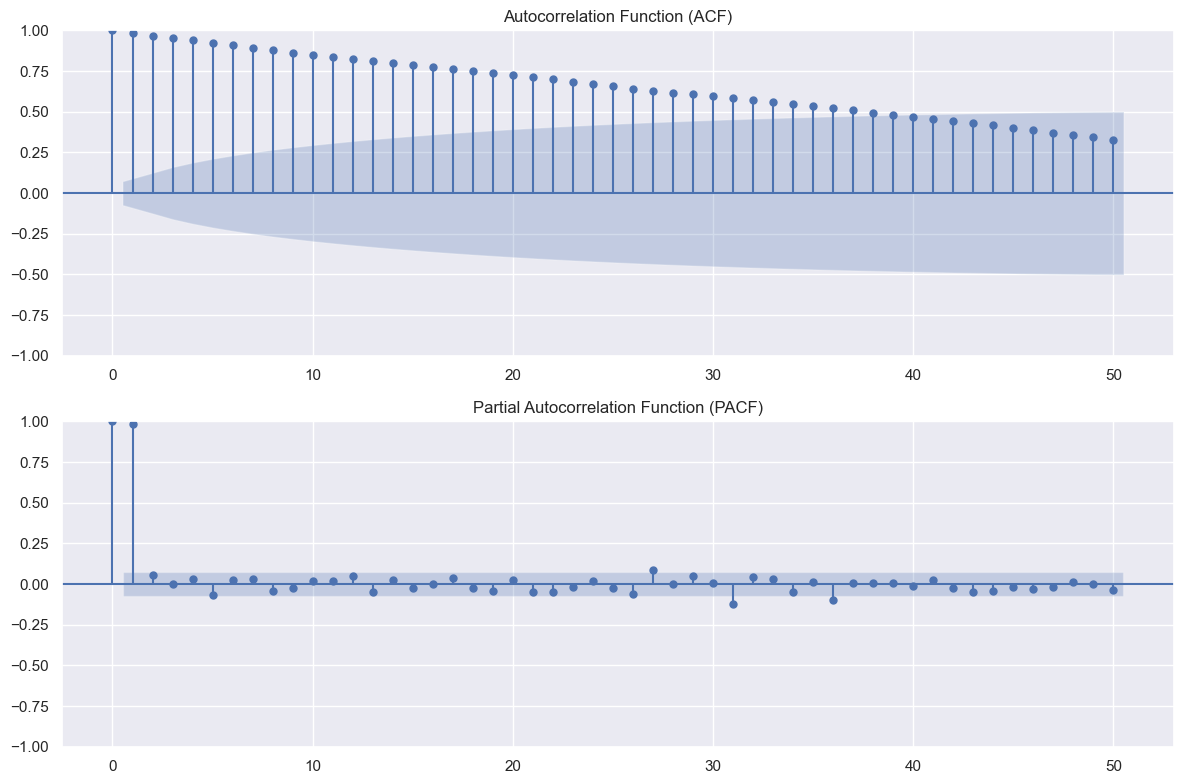

In [32]:
autocorrelation_viz(data=analyzed_df, time_frame=time_frame)

# The PACF plot indicates that a good estimate for the autocorrelative component (p) is 3. Since the ACF plot suggests stationarity, a statistical test like the Augmented Dickey-Fuller (ADF) can test to check for stationarity. 

In [33]:
def ADF_test(data: pd.DataFrame, time_frame: int):
    df = data.copy()
    price = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, f'{time_frame}_Minute_Close']
    result = adfuller(price)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
    if result[1] > 0.05:
        print("Since the p value is greater than 0.05, We must conclude that the series in non-stationary. Now, we must difference in order to make it a stationary time series.")
        differenced_close_prices = price.diff().dropna()
        result = adfuller(differenced_close_prices)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        
        plt.figure(figsize=(10, 4))
        plt.plot(differenced_close_prices)
        plt.title('Differenced Series')
        plt.show()
        
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        
        plot_acf(differenced_close_prices, lags=50, ax=ax[0])
        ax[0].set_title('ACF of Differenced Series')
        
        plot_pacf(differenced_close_prices, lags=50, ax=ax[1])
        ax[1].set_title('PACF of Differenced Series')
        
        plt.tight_layout()
        plt.show()
    else:
        print("The series is stationary. No differencing is needed.")

ADF Statistic: -2.379364590365488
p-value: 0.14764549882432093
Since the p value is greater than 0.05, We must conclude that the series in non-stationary. Now, we must difference in order to make it a stationary time series.
ADF Statistic: -28.622828789032916
p-value: 0.0


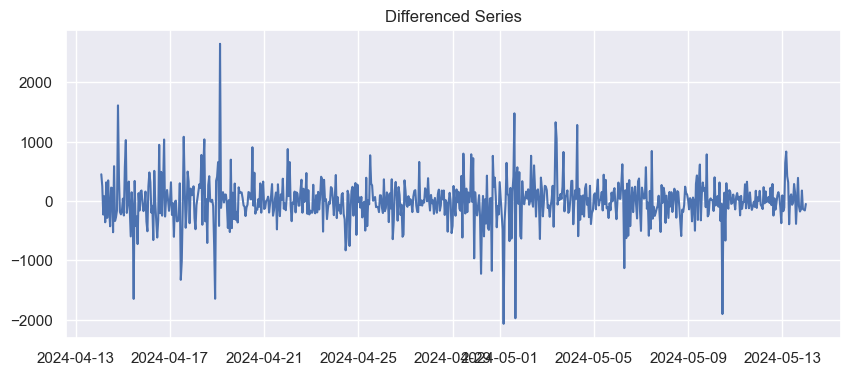

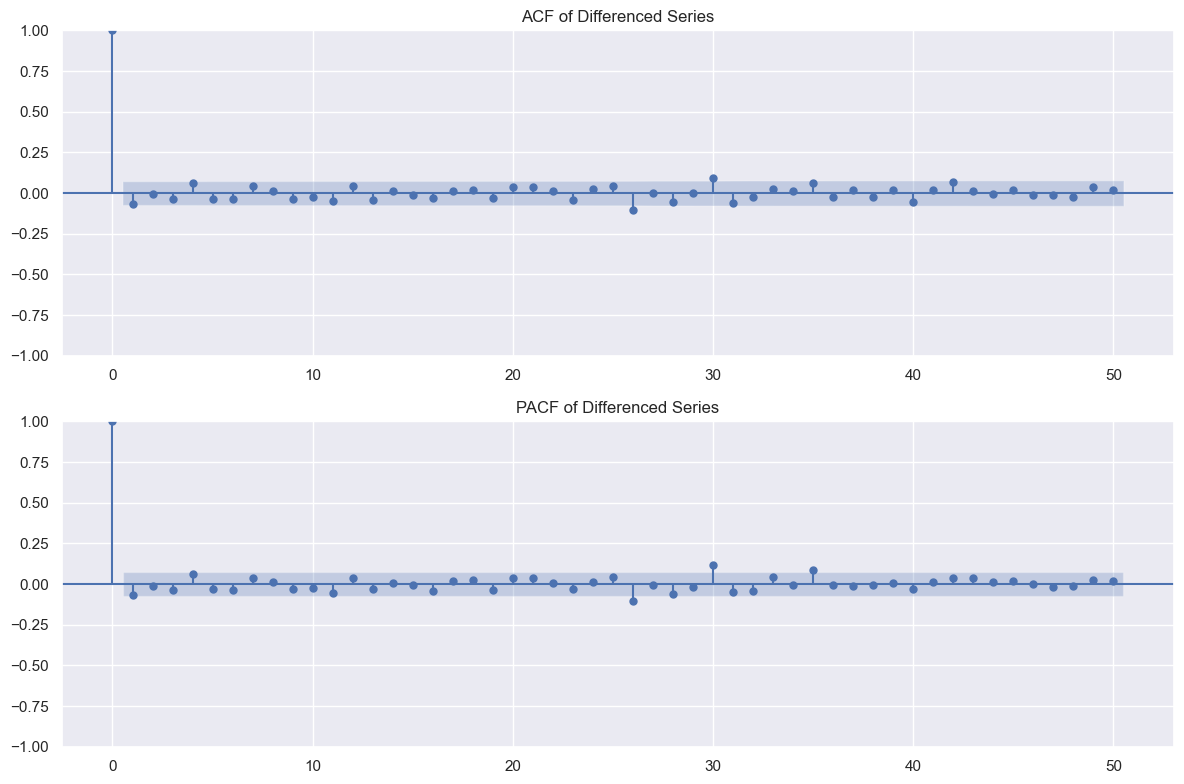

In [34]:
ADF_test(data=analyzed_df, time_frame=time_frame)

# The first order differencing resulted in an ACF plot and PACF plot that indicate a good moving average order (q=2) and a good autoregressive order (p=2), as well as a good differencing order (d=1)

# Now to determine a good seasonal order for the SARIMAX model

In [35]:
def seasonal_decomposition(data: pd.DataFrame, time_frame: int):
    df = data.copy()
    price = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, f'{time_frame}_Minute_Close']
    for s in [10, 50, 100, 150, 200, 360]:
        print(f'{s}\n--------------------------')
        decomposition = seasonal_decompose(price, period=s, model='additive')
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
    
        # Plot decomposition
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
        ax1.plot(price, label='Original')
        ax1.legend(loc='upper left')
        ax2.plot(trend, label='Trend')
        ax2.legend(loc='upper left')
        ax3.plot(seasonal, label='Seasonal')
        ax3.legend(loc='upper left')
        ax4.plot(residual, label='Residual')
        ax4.legend(loc='upper left')
        plt.suptitle(f'Seasonal Decomposition with period={s}')
        plt.tight_layout()
        plt.show()

10
--------------------------


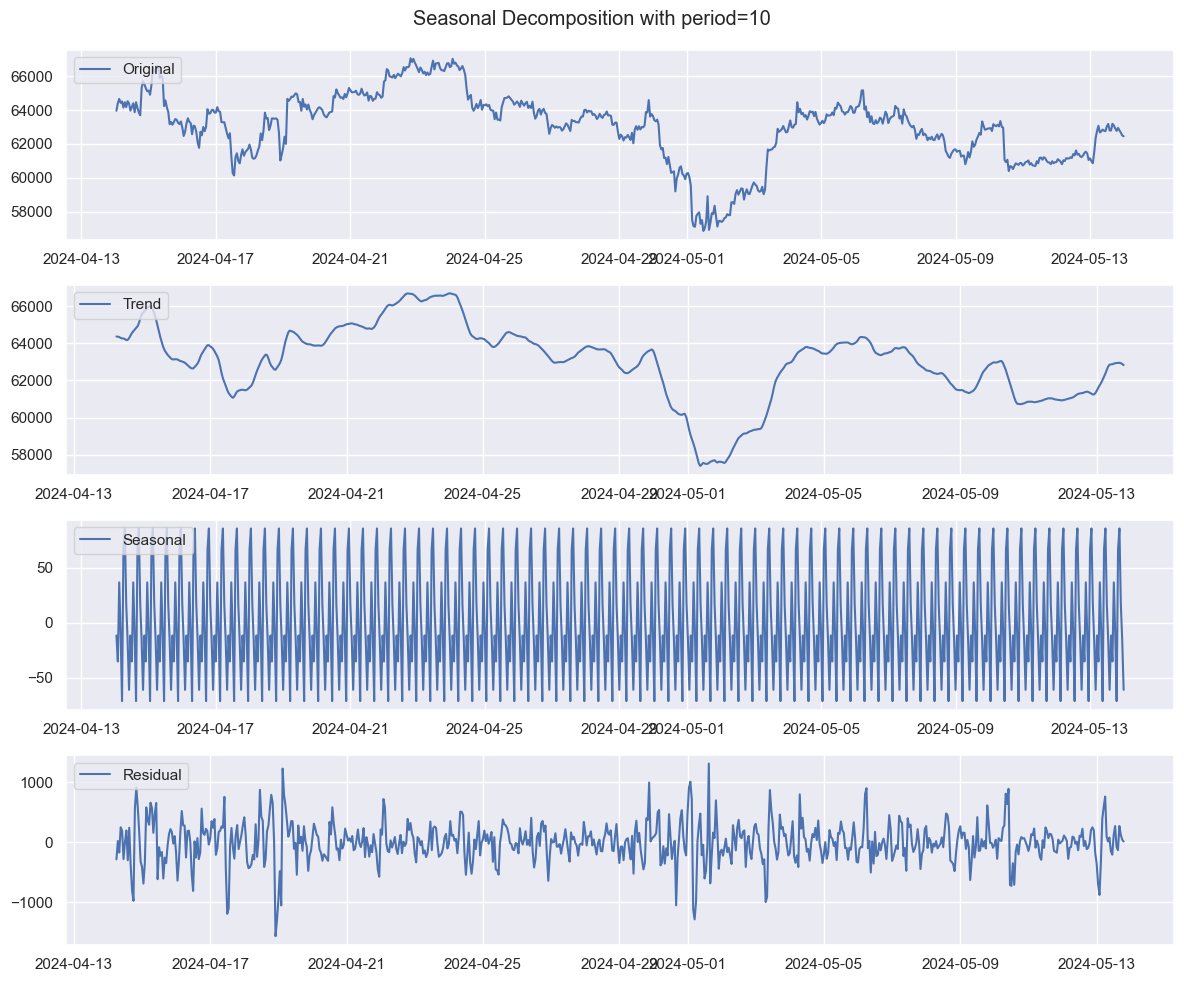

50
--------------------------


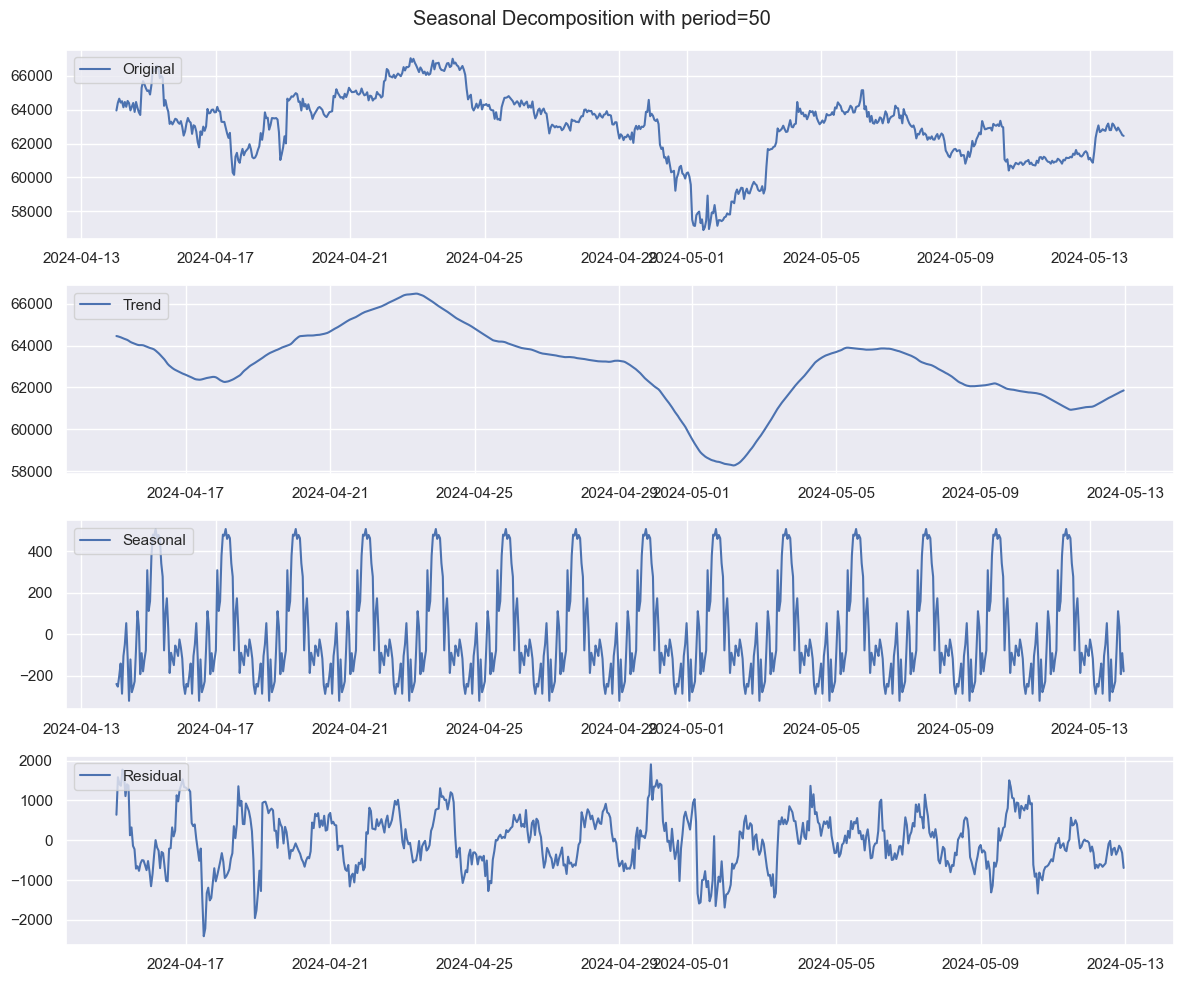

100
--------------------------


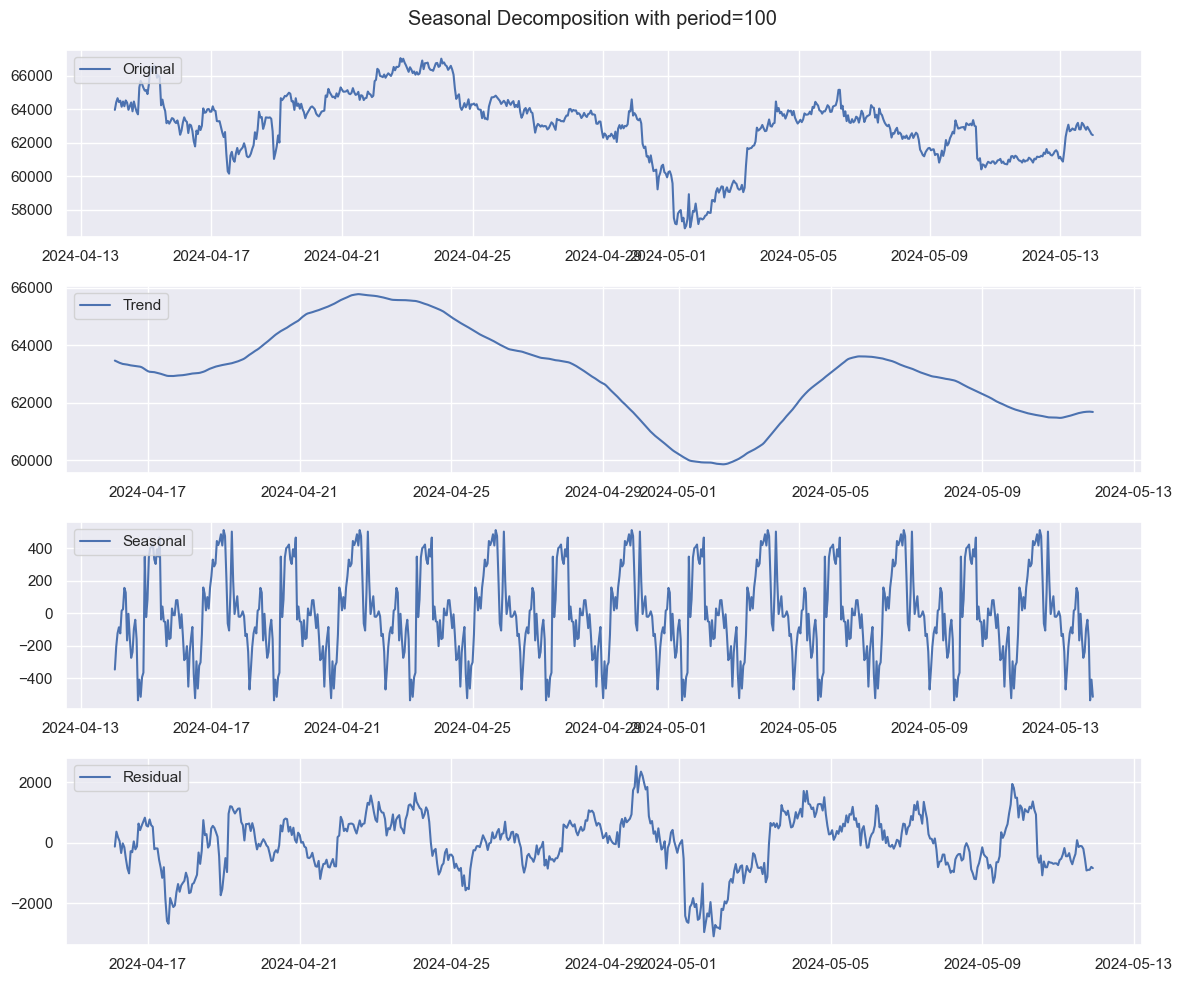

150
--------------------------


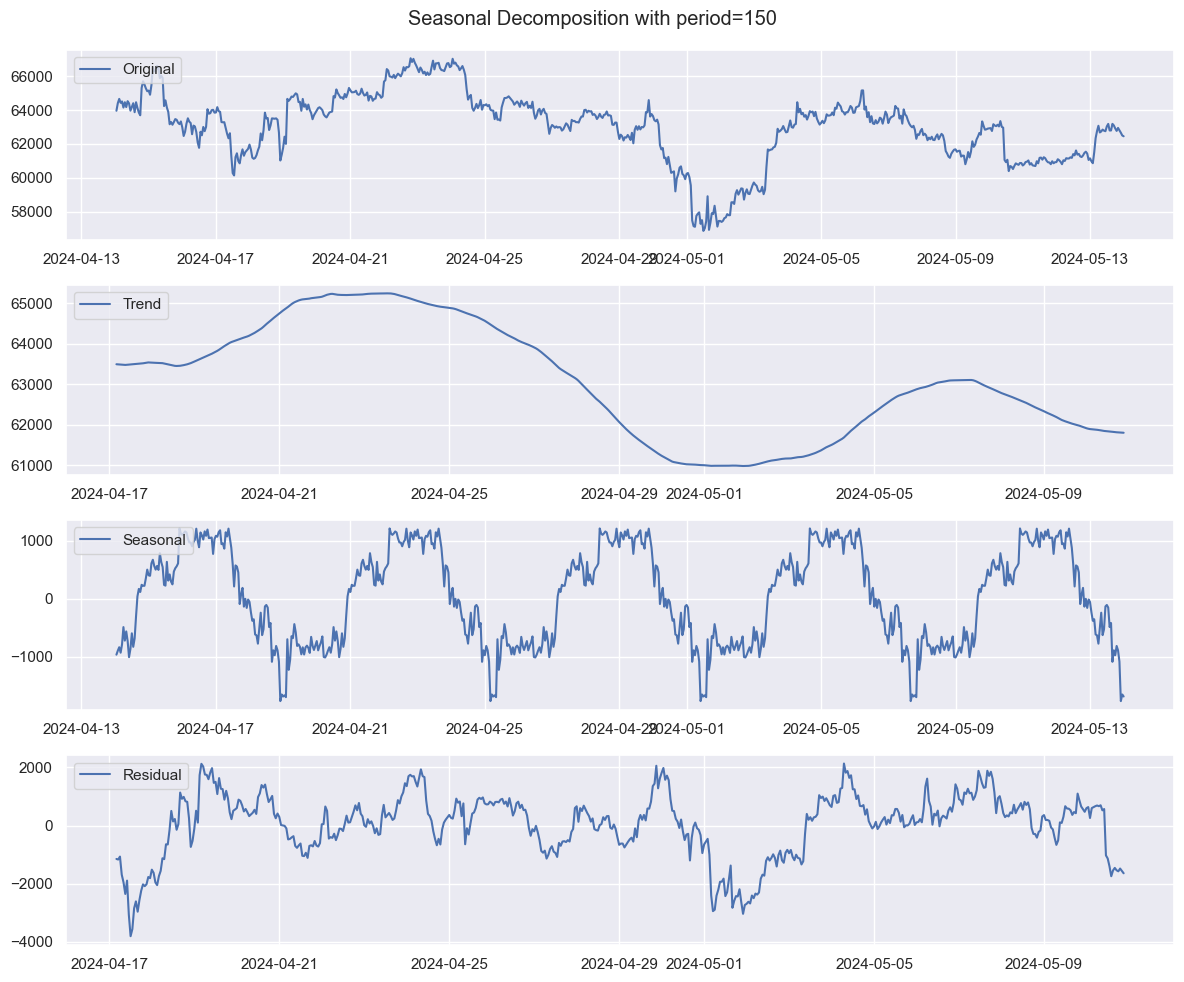

200
--------------------------


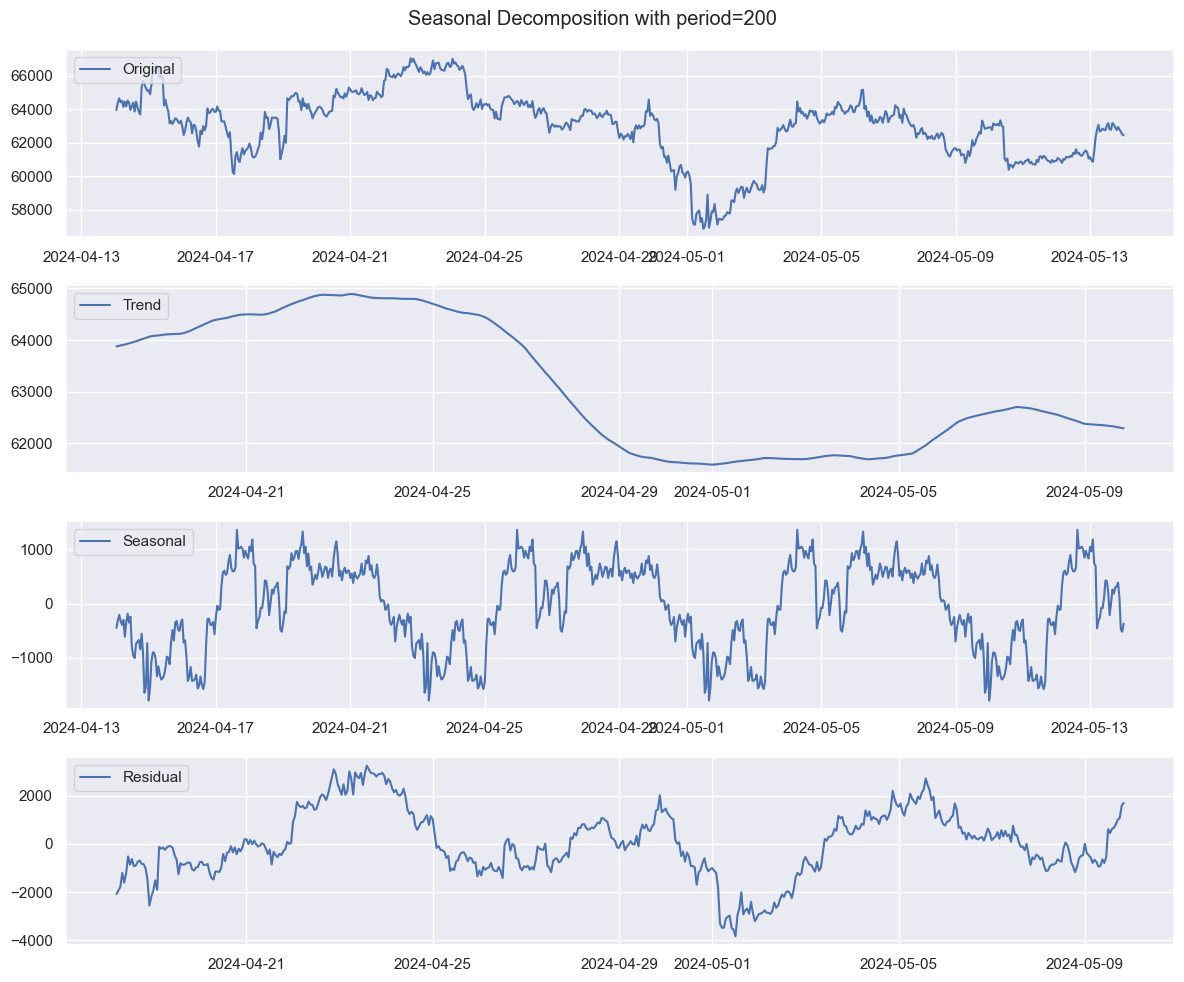

360
--------------------------


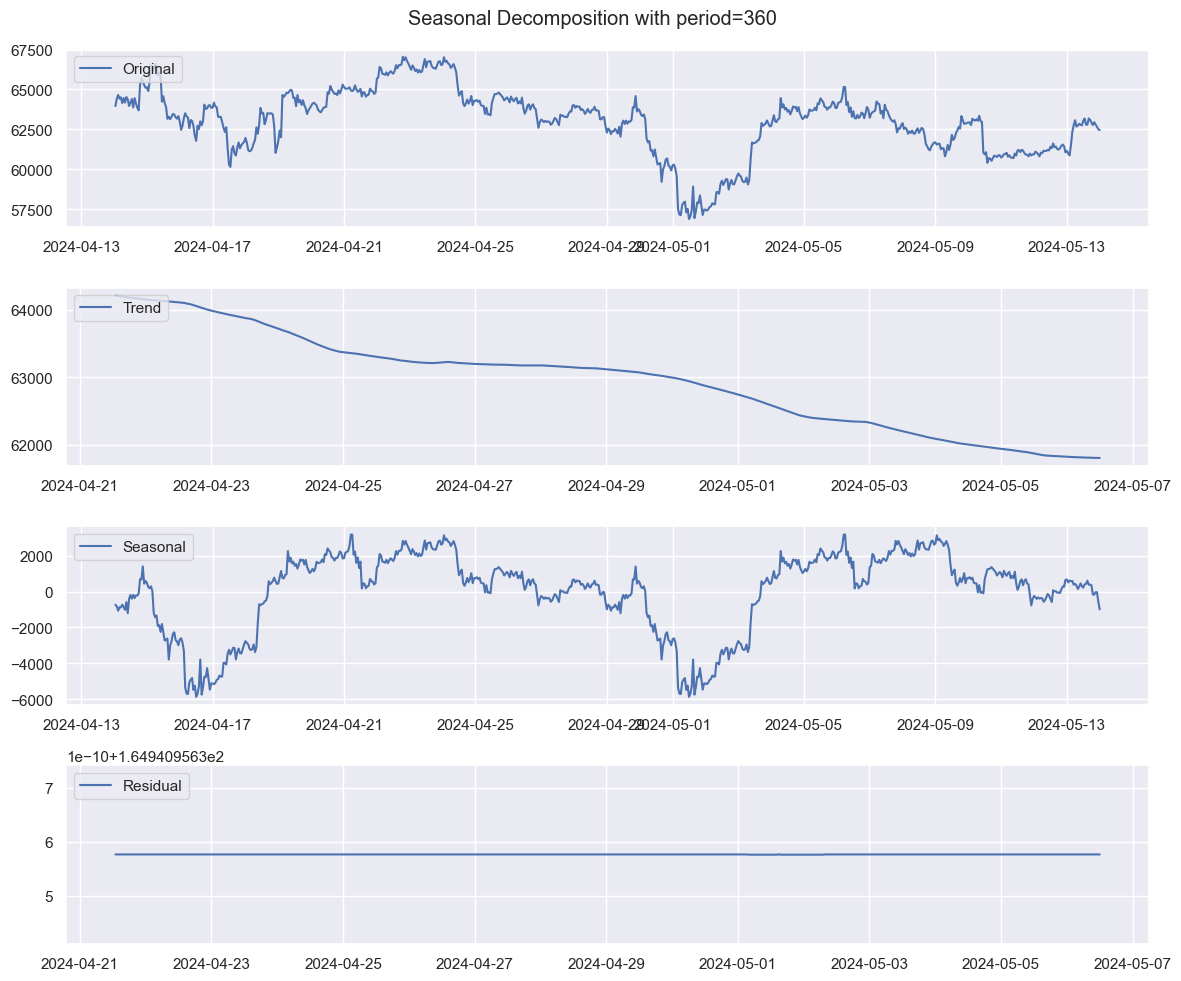

In [36]:
seasonal_decomposition(data=analyzed_df, time_frame=time_frame)

# A good seasonal component (s) seems to be around 100. Now to find P, D, and Q.

In [37]:
def seasonal_ACF_plot(data: pd.DataFrame, time_frame: int, s: int = 100):
    df = data.copy()
    price = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, f'{time_frame}_Minute_Close']
    seasonal_diff = price.diff(s).dropna()
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(seasonal_diff, lags=10, ax=ax[0])
    ax[0].set_title('ACF')
    plot_pacf(seasonal_diff, lags=10, ax=ax[1])
    ax[1].set_title('PACF')
    plt.tight_layout()
    plt.show()

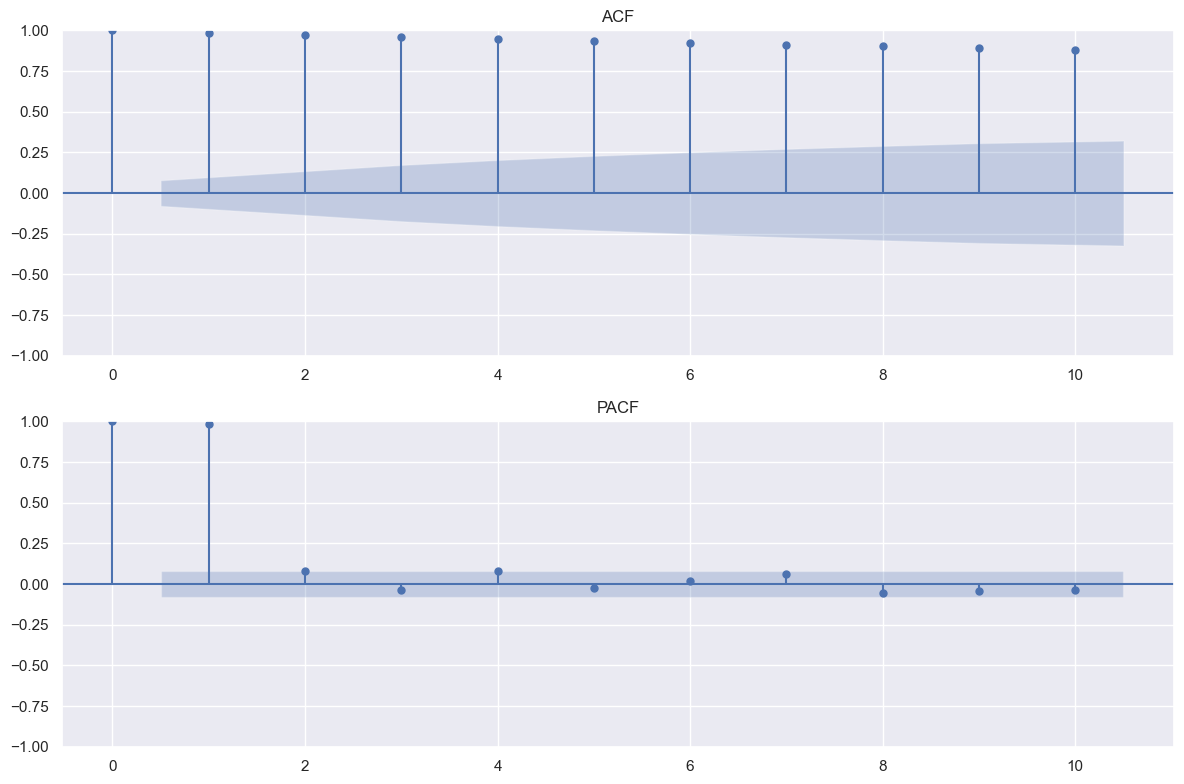

In [38]:
seasonal_ACF_plot(data=analyzed_df, time_frame=time_frame)

# The seasonal ACF plot lacking spikes in the data suggests that there might not be a strong seasonal component in the data. 
# I will use the auto_arima in order to find good values for P, D, and Q, which are the seasonal order components of the SARIMA model.

In [39]:
def apply_auto_arima(data: pd.DataFrame, time_frame: int, series: str):
    df = data.copy()
    df = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, :]
    
    # Fit auto_arima model to find the best parameters
    auto_model = auto_arima(
        df[series].dropna(), 
        m=100, 
        trace=True, 
        error_action='ignore', 
        suppress_warnings=True, 
        stepwise=True,
        start_p=1, max_p=3,
        start_q=1, max_q=3,
        seasonal=True,
        start_P=0, max_P=1,
        start_Q=0, max_Q=1,
        d=1,
        D=0
    )

    # Print the best model parameters
    print(auto_model.summary())
    
    # Extract the best order and seasonal order
    best_order = auto_model.order
    best_seasonal_order = auto_model.seasonal_order
    return best_seasonal_order

In [40]:
seasonal_order = apply_auto_arima(data=analyzed_df, time_frame=time_frame, series=f'{time_frame}_Minute_Close')
seasonal_order

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[100] intercept   : AIC=10579.820, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[100] intercept   : AIC=10580.183, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[100] intercept   : AIC=10582.476, Time=25.54 sec
 ARIMA(0,1,1)(0,0,1)[100] intercept   : AIC=10582.468, Time=10.63 sec
 ARIMA(0,1,0)(0,0,0)[100]             : AIC=10578.206, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[100] intercept   : AIC=10580.946, Time=38.86 sec
 ARIMA(0,1,0)(0,0,1)[100] intercept   : AIC=10580.931, Time=71.61 sec
 ARIMA(0,1,0)(1,0,1)[100] intercept   : AIC=10582.864, Time=54.63 sec
 ARIMA(1,1,0)(0,0,0)[100] intercept   : AIC=10581.759, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[100] intercept   : AIC=10581.763, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[100]          
Total fit time: 201.651 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SA

(0, 0, 0, 100)

# The AIC and BIC suggest this model does not exhibit goodness of fit
# The data is heteroskedastic, which suggests that maybe the data would be better suited to a logarithmic version of itself

In [41]:
logarithmic_seasonal_order = apply_auto_arima(data=analyzed_df, time_frame=time_frame, series=f'log_{time_frame}_Minute_Close')
logarithmic_seasonal_order

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[100] intercept   : AIC=-4961.372, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[100] intercept   : AIC=-4768.526, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[100] intercept   : AIC=-4795.716, Time=48.44 sec
 ARIMA(0,1,1)(0,0,1)[100] intercept   : AIC=inf, Time=229.53 sec
 ARIMA(0,1,0)(0,0,0)[100]             : AIC=-4770.524, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[100] intercept   : AIC=-4963.282, Time=123.26 sec
 ARIMA(1,1,1)(1,0,1)[100] intercept   : AIC=-4959.903, Time=184.59 sec
 ARIMA(1,1,1)(0,0,1)[100] intercept   : AIC=-4963.352, Time=96.78 sec
 ARIMA(1,1,0)(0,0,1)[100] intercept   : AIC=-4795.535, Time=179.83 sec
 ARIMA(2,1,1)(0,0,1)[100] intercept   : AIC=-4960.372, Time=24.77 sec
 ARIMA(1,1,2)(0,0,1)[100] intercept   : AIC=-5019.776, Time=77.00 sec
 ARIMA(1,1,2)(0,0,0)[100] intercept   : AIC=-5017.255, Time=0.13 sec
 ARIMA(1,1,2)(1,0,1)[100] intercept   : AIC=-5017.347, Time=80.48 sec
 ARIMA(1,1,2)(1,0,0)[100] intercept   : AIC=-5046.807

(1, 0, 0, 100)

# Now the logarithmic price seems to have definitely removed heteroskedasticity and has increased the AIC and BIC goodness of fit metrics

# Best model: ARIMA(0,1,2)(1,0,0)[100]   
## Now that we know the correct order (p=0, d=1, q=2) and the seasonal order (P=1, D=0, Q=0, s=100), we can build an optimal sarimax model to forecast the future price.

In [42]:
def sarimax_forecast(data: pd.DataFrame, order: tuple, seasonal_order: tuple, time_frame: int = 1, steps: int = 5):
    """
    Fit and forecast using a SARIMA model.

    Parameters:
    ohlcv_data (np.ndarray or pd.DataFrame): OHLCV data.
    order (tuple): The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
    seasonal_order (tuple): The (P,D,Q,s) seasonal order of the model.
    steps (int): Number of steps to forecast.

    Returns:
    np.ndarray: Forecasted values.
    """
    df = data.copy()
    df = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, :]
    model = SARIMAX(df[f'log_{time_frame}_Minute_Close'], order=order, seasonal_order=seasonal_order)
    sarima_result = model.fit(disp=False)
    forecast = sarima_result.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean.values
    
    # Plotting the actual and forecasted values
    plt.figure(figsize=(10, 6))
    forecast_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=f'{time_frame}min')[-steps:]
    plt.plot(df.index.values[-steps:], df[f'log_{time_frame}_Minute_Close'].values[-steps:], label='Actual')
    plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('SARIMA Forecast')
    plt.legend()
    plt.show()

    mse = mean_squared_error(df[f'log_{time_frame}_Minute_Close'][-steps:], forecast_values)
    mae = mean_absolute_error(df[f'log_{time_frame}_Minute_Close'][-steps:], forecast_values)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(sarima_result.summary())

    with open('sarimax_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    return model, forecast_values

In [43]:
steps = 100
p = 0
d = 1
q = 2
P = 1
D = 0
Q = 0
s = 100

C:\Python\Python3_11_7\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

C:\Python\Python3_11_7\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

C:\Python\Python3_11_7\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



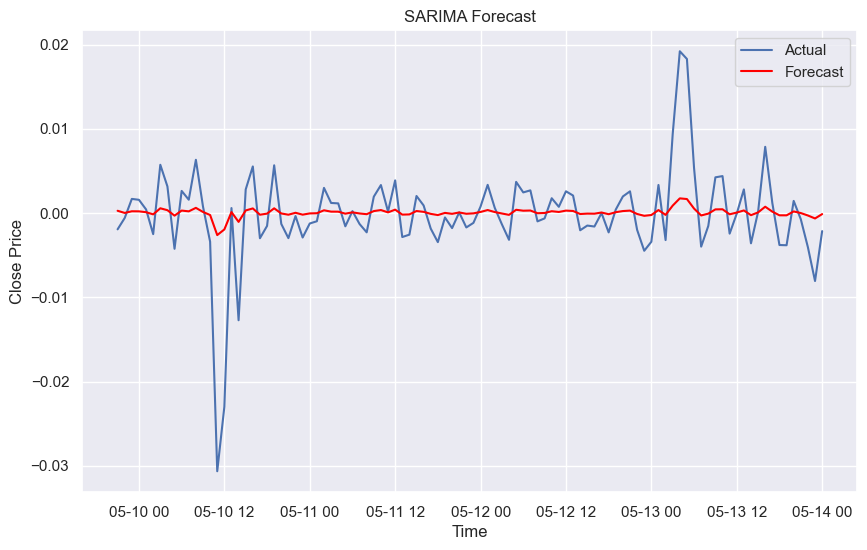

Mean Squared Error: 2.6662003027845545e-05
Mean Absolute Error: 0.003061039308333715
                                      SARIMAX Results                                       
Dep. Variable:                  log_60_Minute_Close   No. Observations:                  720
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 100)   Log Likelihood                2535.721
Date:                              Fri, 17 May 2024   AIC                          -5063.441
Time:                                      15:31:10   BIC                          -5045.130
Sample:                                  04-14-2024   HQIC                         -5056.372
                                       - 05-13-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1        

In [44]:
sarimax_model, sarimax_forecast_values = sarimax_forecast(data=analyzed_df, order=(p, d, q), seasonal_order=(P, D, Q, s), time_frame=time_frame, steps=steps)

# The results show that although the optimal hyperparameters were chosen, the SARIMAX time series forecasting algorithm isn't suited to this data.

# Now to apply the GARCH model to forecast volatility. We will do so using the log returns

# In financial time series analysis, returns are often calculated using the logarithm of the ratio of consecutive prices

$Log \space Return_t = ln(\frac{P_t}{P_{t-1}})$

# Let's find the correct p and q values for the GARCH model

In [45]:
# Function to fit GARCH model and return AIC (Akaike information criterion), which is a goodness of fit method
def fit_garch_model(log_returns: pd.Series, p: int, q: int):
    model = arch_model(log_returns, vol='Garch', p=p, q=q)
    result = model.fit(disp='off')
    return result.aic

def find_garch_components(data: pd.DataFrame, time_frame: int):
    df = data.copy()
    df = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, :]
    log_returns = np.log(df[f'{time_frame}_Minute_Close']).diff().dropna()
    
    # Define a range for p and q
    p_range = range(1, 5)
    q_range = range(1, 5)
    
    # Perform grid search
    best_aic = np.inf
    best_p = None
    best_q = None
    
    for p in p_range:
        for q in q_range:
            try:
                aic = fit_garch_model(log_returns, p, q)
                if aic < best_aic:
                    best_aic = aic
                    best_p = p
                    best_q = q
            except:
                continue

    print(f'Best GARCH model: p={best_p}, q={best_q}, AIC={best_aic}')
    return best_p, best_q, best_aic

In [46]:
best_p, best_q, best_aic = find_garch_components(data=analyzed_df, time_frame=time_frame)
best_p, best_q, best_aic

C:\Python\Python3_11_7\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.696e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


C:\Python\Python3_11_7\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.696e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


C:\Python\Python3_11_7\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, w

Best GARCH model: p=1, q=4, AIC=-5372.629968739509


(1, 4, -5372.629968739509)

# The best garch components can now be used to train an optimal garch volatility forecasting model

In [47]:
def garch_forecast(data: pd.DataFrame, time_frame: int, p: int, q: int):
    df = data.copy()
    df = df.loc[df[f'{time_frame}_Minute_Complete_Candle'] == 1, :]
    log_returns = np.log(df[f'{time_frame}_Minute_Close']).diff().dropna()
    
    # Fit the best GARCH model
    model = arch_model(log_returns, vol='Garch', p=p, q=q)
    result = model.fit(disp='off')
    
    print(result.summary())
    
    # Forecast future volatility
    steps = 500
    forecast = result.forecast(horizon=steps)
    forecast_variance = forecast.variance.values[-1, :]
    forecast_volatility = np.sqrt(forecast_variance)
        
    # Plot the results
    plt.figure(figsize=(10, 6))

    forecast_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=f'{time_frame}min')[-steps:]
    plt.plot(df.index.values[-steps:], df[f'log_{time_frame}_Minute_Close'].values[-steps:], label='Log Returns')
    plt.plot(forecast_index, forecast_volatility, label='Forecasted Volatility', color='red')
    plt.xlabel('Time')
    plt.ylabel('Log Returns / Volatility')
    plt.title('GARCH Model Forecast')
    plt.legend()
    plt.show()
    
    log_mse = mean_squared_error(df[f'log_{time_frame}_Minute_Close'].values[-steps:], forecast_volatility)
    log_rmse = np.sqrt(log_mse)
    log_mae = mean_absolute_error(df[f'log_{time_frame}_Minute_Close'].values[-steps:], forecast_volatility)

    print(f'Root Mean Squared Error of log: {log_rmse}')
    print(f'Mean Squared Error of log: {log_mse}')
    print(f'Mean Absolute Error of log: {log_mae}')

    # Plot the results
    plt.figure(figsize=(10, 6))

    forecast_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=f'{time_frame}min')[-steps:]
    upper_bound = forecast_volatility + df[f'{time_frame}_Minute_Close'].values[-steps:]
    lower_bound = forecast_volatility + df[f'{time_frame}_Minute_Close'].values[-steps:]
    plt.plot(df.index.values[-steps:], df[f'{time_frame}_Minute_Close'].values[-steps:], label='Log Returns', ls='--')
    plt.plot(forecast_index, upper_bound, label='Upper Forecasted Volatility', color='purple', ls=':')
    plt.plot(forecast_index, lower_bound, label='Lower Forecasted Volatility', color='purple', ls=':')
    plt.xlabel('Time')
    plt.ylabel('Log Returns / Volatility')
    plt.title('GARCH Model Forecast')
    plt.legend()
    plt.show()
    
    # Calculate error metrics (for illustrative purposes, comparing forecasted volatility with actual future returns)
    mse = mean_squared_error(df[f'{time_frame}_Minute_Close'].values[-steps:], df[f'{time_frame}_Minute_Close'].values[-steps:] + forecast_volatility)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df[f'{time_frame}_Minute_Close'].values[-steps:], df[f'{time_frame}_Minute_Close'].values[-steps:] + forecast_volatility)

    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    with open('garch_model.pkl', 'wb') as file:
        pickle.dump(model, file)

    return model, forecast

C:\Python\Python3_11_7\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.696e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




                     Constant Mean - GARCH Model Results                      
Dep. Variable:        60_Minute_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2693.31
Distribution:                  Normal   AIC:                          -5372.63
Method:            Maximum Likelihood   BIC:                          -5340.58
                                        No. Observations:                  719
Date:                Fri, May 17 2024   Df Residuals:                      718
Time:                        15:31:16   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.4936e-05  2.792e-05      0.535      0.593 

C:\Python\Python3_11_7\Lib\site-packages\arch\univariate\base.py:2050: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



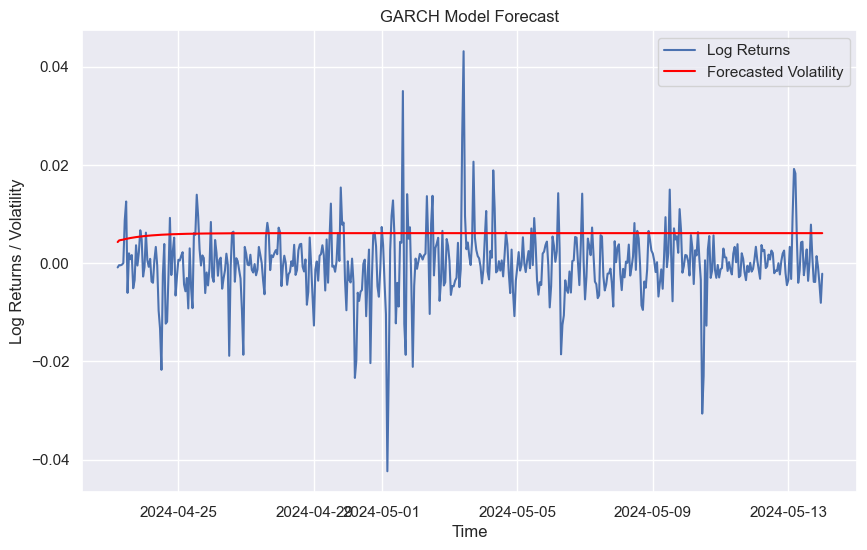

Root Mean Squared Error of log: 0.009299651662462704
Mean Squared Error of log: 8.648352104314533e-05
Mean Absolute Error of log: 0.007325102263687291


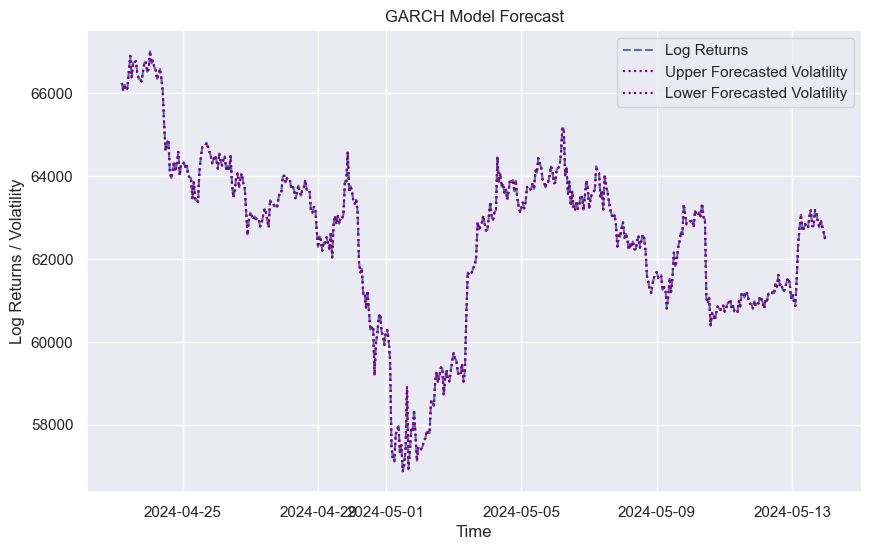

Root Mean Squared Error: 0.006065079913659353
Mean Squared Error: 3.678519435907415e-05
Mean Absolute Error: 0.006061038269646815


In [48]:
garch_model, forecast_volatility = garch_forecast(data=analyzed_df, time_frame=time_frame, p=best_p, q=best_q)

# This GARCH volatility forecasting model assumes oversimplicity and could not be relied on to accurately predict the price or volatility

# Now to use prepare data for ml

In [49]:
class MLData:
    def __init__(self, data: pd.DataFrame, target_features: list, time_frame: int, lag: int = 3):
        self.time_frame = time_frame
        self.data = self.isolate_time_frame(data=data.copy())
        self.target_features = target_features
        self.target_data = self.data[target_features].iloc[lag:, :].apply(pd.to_numeric, errors='coerce').values
        self.target_size = len(self.target_features)
        self.input_features = self.data.drop(self.target_features, axis=1).columns
        self.input_data = self.create_lagged_input_data(lag=lag)
        self.input_size = len(self.input_features)

    def isolate_time_frame(self, data: pd.DataFrame):
        df = data.loc[data[f'{time_frame}_Minute_Complete_Candle'] == 1, :].drop([f'{time_frame}_Minute_Complete_Candle', 'Date', 'Time', f'{time_frame}_Minute_Candle_Counter'], axis=1).reset_index()    
        relevant_columns = ['Time_Stamp', *[i for i in df.columns if i.startswith(f'{time_frame}_Minute')]]
        df = df[relevant_columns]
        df = fill_in_missing_rows(data=df).drop(['Date', 'Time'], axis=1).reset_index()
        df = df.apply(pd.to_numeric, errors='coerce')
        return df

    def create_lagged_input_data(self, lag: int):
        
        cols = self.data.columns
        for col in cols:
            for l in range(1, lag + 1):
                self.data[f'{col}_lag{l}']=self.data[col].shift(l)
                for i in range(l):
                    self.data.loc[i,f'{col}_lag{l}'] = self.data.loc[i,col] 
        
        lagged_data = self.data[self.input_features].shift(lag)
        lagged_data = lagged_data.reset_index(drop=True).iloc[lag:, :]
        return lagged_data.apply(pd.to_numeric, errors='coerce').values

In [50]:
target_features = [f'{time_frame}_Minute_Open', f'{time_frame}_Minute_High', f'{time_frame}_Minute_Low', f'{time_frame}_Minute_Close', f'{time_frame}_Minute_Volume']
lag = 3
ml_data = MLData(data=analyzed_df.reset_index(), target_features=target_features, time_frame=time_frame, lag=lag)

In [51]:
ml_data.data

Time_Stamp  60_Minute_Start_Time  60_Minute_Open  \
0      1713056340000000000   1713052860000000000        63956.87   
1      1713056400000000000   1713052860000000000        63956.87   
2      1713056460000000000   1713052860000000000        63956.87   
3      1713056520000000000   1713052860000000000        63956.87   
4      1713056580000000000   1713052860000000000        63956.87   
...                    ...                   ...             ...   
43136  1715644500000000000   1715637600000000000        62503.25   
43137  1715644560000000000   1715637600000000000        62503.25   
43138  1715644620000000000   1715637600000000000        62503.25   
43139  1715644680000000000   1715637600000000000        62503.25   
43140  1715644740000000000   1715641200000000000        62452.45   

       60_Minute_High  60_Minute_Low  60_Minute_Close  60_Minute_Volume  \
0            63956.87       63956.87         63956.87         40.506893   
1            63956.87       63956.87         63956.87         35.677447   
2            63956.87       63956.87         63956.87         35.677447   
3            63956.87       63956.87         63956.87         35.677447   
4            63956.87       63956.87         63956.87         35.677447   
...               ...            ...              ...               ...   
43136        62503.25       62503.25         62503.25         57.046374   
43137        62503.25       62503.25         62503.25         57.046374   
43138        62503.25       62503.25         62503.25         57.046374   
43139        62503.25       62503.25         62503.25         57.046374   
43140        62452.45       62452.45         62452.45         59.300999   

       60_Minute_Delta0  60_Minute_MA20  60_Minute_STD20  ...  \
0            63761.8925    63761.952750        12.960681  ...   
1            63761.8925    63761.952750        12.960681  ...   
2            63761.8925    63761.952750        12.960681  ...   
3            63761.8925    63761.952750        12.960681  ...   
4            63761.8925    63761.952750        12.960681  ...   
...                 ...             ...              ...  ...   
43136        62579.9025    62603.664375         9.879729  ...   
43137        62579.9025    62603.664375         9.879729  ...   
43138        62579.9025    62603.664375         9.879729  ...   
43139        62579.9025    62603.664375         9.879729  ...   
43140        62486.9800    62485.394875        10.145728  ...   

       60_Minute_MIN_lag3  60_Minute_SMA_lag1  60_Minute_SMA_lag2  \
0                63503.91        63782.351896        63782.351896   
1                63503.91        63782.351896        63782.351896   
2                63503.91        63782.351896        63782.351896   
3                63503.91        63782.351896        63782.351896   
4                63503.91        63782.351896        63782.351896   
...                   ...                 ...                 ...   
43136            62507.60        62592.312033        62592.312033   
43137            62507.60        62592.312033        62592.312033   
43138            62507.60        62592.312033        62592.312033   
43139            62507.60        62592.312033        62592.312033   
43140            62507.60        62592.312033        62592.312033   

       60_Minute_SMA_lag3  60_Minute_STD_lag1  60_Minute_STD_lag2  \
0            63782.351896            4.412346            4.412346   
1            63782.351896            4.412346            4.412346   
2            63782.351896            4.412346            4.412346   
3            63782.351896            4.412346            4.412346   
4            63782.351896            4.412346            4.412346   
...                   ...                 ...                 ...   
43136        62592.312033            8.690342            8.690342   
43137        62592.312033            8.690342            8.690342   
43138        62592.312033            8.690342            8.690342  

In [52]:
print(f'Input Data Shape: {ml_data.input_data.shape}\nTarget Data Shape: {ml_data.target_data.shape}')

Input Data Shape: (43138, 21)
Target Data Shape: (43138, 5)


In [53]:
print(f'Input Data NaNs: {np.isnan(ml_data.input_data).sum()}\nTarget Data NaNs: {np.isnan(ml_data.target_data).sum()}')

Input Data NaNs: 0
Target Data NaNs: 0


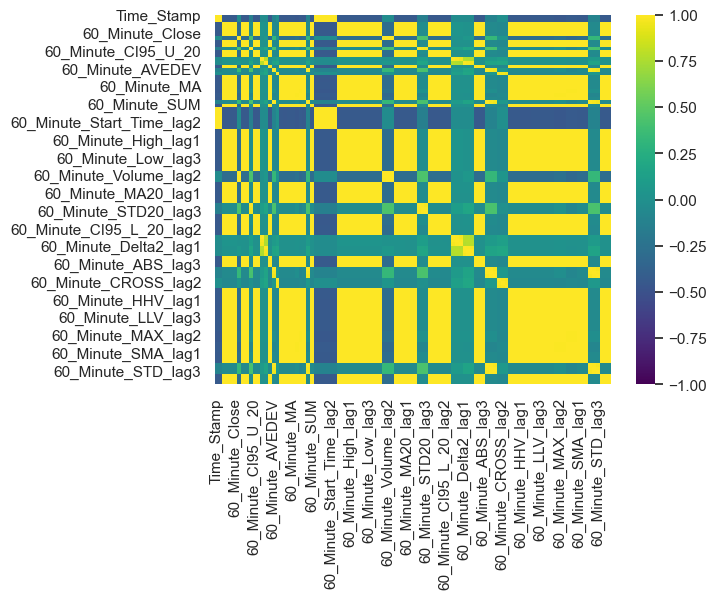

In [54]:
correlation_matrix = ml_data.data.corr()
correlation_matrix
sns.heatmap(data=correlation_matrix, vmin=-1, vmax=1, cmap='viridis', annot=False, cbar=True)
plt.show()

# LSTM is a very good method of avoiding a vanishing gradient, which is expected to outperform linear regression, as well as SARIMAX and GARCH forecasting.

In [60]:
class TimeSeriesAttention(nn.Module):
    def __init__(self, input_size, num_heads, head_size, dropout=0.1):
        super(TimeSeriesAttention, self).__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, input_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        T = x.size(1)
        mask = torch.tril(torch.ones(T, T)).to(x.device)
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class Head(nn.Module):
    def __init__(self, head_size):
        super(Head, self).__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)
        wei = wei.masked_fill(mask == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        out = wei @ v
        return out

In [61]:
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, sequence_length: int, dropout=0.2):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_length = sequence_length

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  # Update dimensions here

        out, _ = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out

In [62]:
class GenericNN(nn.Module):
    layer_dict = {
        0: (nn.Linear, {}),  # Example output features
        1: (nn.LSTM, {}),
        2: nn.ReLU,
        3: nn.Softmax,
        4: (nn.Conv1d, {'out_channels': 16, 'kernel_size': 3, 'stride': 1}),
        5: (nn.Conv2d, {'out_channels': 16, 'kernel_size': 3, 'stride': 1}),
        6: (nn.Conv3d, {'out_channels': 16, 'kernel_size': 3, 'stride': 1}),
        7: (nn.BatchNorm1d, {}),
        8: (nn.BatchNorm2d, {}),
        9: (nn.BatchNorm3d, {}),
        10: (nn.Dropout, {'p': 0.5}),
        11: (nn.Dropout2d, {'p': 0.5}),
        12: (nn.Dropout3d, {'p': 0.5}),
        13: (nn.Embedding, {'num_embeddings': 1000, 'embedding_dim': 50}),
        14: nn.Tanh,
        15: nn.Sigmoid,
        16: nn.LeakyReLU,
        17: nn.ELU,
        18: nn.SELU,
        19: nn.GELU,
        20: nn.Hardtanh,
        21: nn.Softplus,
        22: nn.Softsign,
        23: nn.LogSigmoid,
        24: nn.Softmax2d,
        25: nn.PReLU,
        26: nn.Mish,
        27: nn.Identity,
        28: (nn.MultiheadAttention, {'embed_dim': 32, 'num_heads': 8}),
        29: (TimeSeriesAttention, {'num_heads': 8}),
        30: (StockPriceRNN, {'input_size': None, 'hidden_size': None, 'num_layers': 2, 'output_size': None, 'dropout': 0.2}),
        31: (nn.RNN, {'input_size': None, 'hidden_size': None, 'num_layers': 2, 'dropout': 0.2})
    }
    
    def __init__(self, ml_data: MLData, hidden_size: int, layers: list, batch_size: int, sequence_length: int):
        super().__init__()
        self.ml_data = ml_data
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.num_layers = len(layers)
        
        self.layers_dict = {}
        self.layers = nn.ModuleList()
        for l in range(len(layers)):
            layer = self.layer_dict[layers[l]]
            is_layer = isinstance(layer, tuple)
            if is_layer:
                nn_layer = layer[0]
                kwargs = layer[1]
            else:
                nn_layer = layer
                kwargs = {}
                
            if l == 0:
                args = (self.ml_data.input_size,)
                self.layers_dict[l] = {
                    'kwargs': {'hidden_size': self.hidden_size, 'num_layers': self.num_layers, **{i: j for i, j in kwargs.items() if i not in ['hidden_size', 'num_layers']}}, 
                    'type': 'input'
                }
                
            elif l == len(layers) - 1:
                if is_layer:
                    args = (self.hidden_size, self.ml_data.target_size)
                    self.layers_dict[l] = {
                        'kwargs': kwargs, 
                        'type': 'output'
                    }
                    
                else:
                    args = tuple()
                    self.layers_dict[l] = {
                        'kwargs': kwargs, 
                        'type': 'output'
                    }
                
            else:
                args = tuple()
                
                if layers[l] == 29:
                    kwargs['input_size'] = self.hidden_size
                    kwargs['head_size'] = self.hidden_size // kwargs['num_heads']
                elif layers[l] == 30:
                    kwargs['input_size'] = self.hidden_size
                    kwargs['hidden_size'] = self.hidden_size
                    kwargs['output_size'] = self.hidden_size  # Assuming hidden_size for output size
                    kwargs['sequence_length'] = self.sequence_length
                elif layers[l] == 31:
                    kwargs['input_size'] = self.hidden_size
                    kwargs['hidden_size'] = self.hidden_size                  
                    
                self.layers_dict[l] = {
                    'kwargs': kwargs, 
                    'type': 'hidden'
                }

            if layers[l] == 0:
                if l == len(layers) - 1:
                    layer_object = nn_layer(in_features=out_features, out_features=self.ml_data.target_size)
                else:
                    layer_object = nn_layer(in_features=out_features, out_features=self.hidden_size)
                    
            elif layers[l] == 3:
                layer_object=nn_layer(dim=1)
            else:
                layer_object = nn_layer(*args, **self.layers_dict[l]['kwargs'])
                
            self.layers.append(layer_object)
            self.layers_dict[l]['layer'] = layer_object
            
            try:
                out_features = self.get_output_size(layer_object,self.hidden_size)
            except:
                out_features = self.hidden_size

    def get_output_size(self, layer, input_size):
        if isinstance(layer, nn.Linear):
            return layer.out_features
        elif isinstance(layer, nn.LSTM):
            return layer.hidden_size  # Correctly handle LSTM layers
        elif isinstance(layer, nn.Conv1d):
            return layer.out_channels
        elif isinstance(layer, nn.Conv2d):
            return layer.out_channels
        elif isinstance(layer, nn.Conv3d):
            return layer.out_channels
        elif isinstance(layer, nn.BatchNorm1d):
            return input_size
        elif isinstance(layer, nn.BatchNorm2d):
            return input_size
        elif isinstance(layer, nn.BatchNorm3d):
            return input_size
        elif isinstance(layer, nn.Dropout):
            return input_size
        elif isinstance(layer, nn.Dropout2d):
            return input_size
        elif isinstance(layer, nn.Dropout3d):
            return input_size
        elif isinstance(layer, nn.Embedding):
            return layer.embedding_dim
        elif isinstance(layer, nn.ReLU):
            return input_size
        elif isinstance(layer, nn.Tanh):
            return input_size
        elif isinstance(layer, nn.Sigmoid):
            return input_size
        elif isinstance(layer, nn.LeakyReLU):
            return input_size
        elif isinstance(layer, nn.ELU):
            return input_size
        elif isinstance(layer, nn.SELU):
            return input_size
        elif isinstance(layer, nn.GELU):
            return input_size
        elif isinstance(layer, nn.Hardtanh):
            return input_size
        elif isinstance(layer, nn.Softplus):
            return input_size
        elif isinstance(layer, nn.Softsign):
            return input_size
        elif isinstance(layer, nn.LogSigmoid):
            return input_size
        elif isinstance(layer, nn.Softmax2d):
            return input_size
        elif isinstance(layer, nn.PReLU):
            return input_size
        elif isinstance(layer, nn.Mish):
            return input_size
        elif isinstance(layer, nn.Identity):
            return input_size
        elif isinstance(layer, nn.MultiheadAttention):
            return input_size
        elif isinstance(layer, TimeSeriesAttention):
            return input_size
        elif isinstance(layer, StockPriceRNN):
            return layer.hidden_size
        elif isinstance(layer, nn.RNN):
            return layer.hidden_size
        else:
            raise ValueError(f"{layer} type not supported")
            
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.sequence_length, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, self.sequence_length, self.hidden_size).to(x.device)

        for layer in self.layers_dict.keys():
            if self.layers_dict[layer]['type'] == 'input':
                out, _ = self.layers_dict[layer]['layer'](x, (h0, c0))
                out = out[:, -1, :]
            elif isinstance(self.layers_dict[layer]['layer'], nn.MultiheadAttention):
                out, _ = self.layers_dict[layer]['layer'](out, out, out)
            elif isinstance(self.layers_dict[layer]['layer'], nn.RNN):
                h0 = torch.zeros(self.layers_dict[layer]['layer'].num_layers, out.size(0), self.layers_dict[layer]['layer'].hidden_size).to(out.device)
                out, _ = self.layers_dict[layer]['layer'](out, h0)
            else:
                out = self.layers_dict[layer]['layer'](out)
                
        return out

In [63]:
class GenericTrainer:
    param_grid = {
        'hidden_size': [32, 64],
        'layers': [[1, 2, 10, 0, 3, 0], [1, 2, 10, 0, 3, 28, 0], [[1, 2, 10, 0, 3, 29, 0], [1, 28, 2, 28, 0, 28, 3, 28, 0]]],
        'learning_rate': [0.001, 0.01],
        'batch_size': [64, 128]
    }
    
    def __init__(
        self, 
        ml_data: MLData, 
        model_name: str = 'custom_model', 
        sequence_length: int = 10, 
        n_epochs: int = 50, 
        param_grid: dict = None
    ):
        
        self.ml_data = ml_data
        self.model_name = model_name
        self.sequence_length = sequence_length
        self.n_epochs = n_epochs
        self.scaler = StandardScaler()
        self.model = None
        self.predictions = None
        
        if param_grid is not None:
            self.param_grid = param_grid

    def save_model(self):
        with open(f'./{self.model_name}.pkl', 'wb') as file:
            pickle.dump(self.model, file)
        
    def create_sequences(self):
        xs, ys = [], []
        for i in range(self.ml_data.input_data.shape[0] - self.sequence_length):
            x = ml_data.input_data[i: i + self.sequence_length]
            y = ml_data.target_data[i + self.sequence_length]
            xs.append(x)
            ys.append(y)

        xs = np.array(xs)
        xs = xs.reshape(xs.shape[0], self.sequence_length, -1)
        ys = np.array(ys)
        return xs, ys
        
    def train_model(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"CUDA {'is' if torch.cuda.is_available() else 'is not'} available for GPU Machine Learning")
        print(f'Device: {device} being used')
        
        # Normalize the data
        self.ml_data.input_data = self.scaler.fit_transform(self.ml_data.input_data)
    
        # Create sequences
        X, y = self.create_sequences()
        
    
        # Convert to PyTorch tensors
        X_tensor = torch.from_numpy(X).float()
        y_tensor = torch.from_numpy(y).float()
        best_mse = float('inf')
        best_params = None
        best_model = None
        criterion = nn.MSELoss()
    
        for params in ParameterGrid(self.param_grid):
            # Recreate DataLoader with current batch_size
            batch_size, hidden_size, layers, learning_rate = params.values()
            print(f'Batch Size - {batch_size}\nHidden Size - {hidden_size}\nLayers - {layers}\nLearning Rate - {learning_rate}')
            dataset = TensorDataset(X_tensor, y_tensor)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
            # Create and train the model with current hyperparameters
            model = GenericNN(
                ml_data=self.ml_data, 
                hidden_size=hidden_size, 
                batch_size=batch_size, 
                sequence_length=self.sequence_length, 
                layers=layers
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
            for epoch in trange(self.n_epochs):
                model.train()
                for inputs, targets in dataloader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
            # Evaluate the model
            model.eval()
            with torch.no_grad():
                predictions = model(X_tensor.to(device)).cpu().numpy()
            
            mse = mean_squared_error(y, predictions)
            if mse < best_mse:
                best_mse = mse
                best_params = params
                best_model = model
    
        print(f'Best Hyperparameters: {best_params}')
        print(f'Best MSE: {best_mse}')
    
        # Make final predictions with the best model
        self.model = best_model
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor.to(device)).cpu().numpy()
    
        # Inverse transform the predictions
        predictions = scaler.inverse_transform(predictions)
    
        # Create a DataFrame for the predictions
        timestamps = self.data.loc[seq_length:, 'Time_Stamp']
        self.predictions = pd.DataFrame(predictions, columns=target_columns, index=timestamps)

In [64]:
lstm = GenericTrainer(ml_data=ml_data)
lstm.train_model()

CUDA is available for GPU Machine Learning
Device: cuda being used
Batch Size - 64
Hidden Size - 32
Layers - [1, 2, 10, 0, 3, 0]
Learning Rate - 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

Batch Size - 64
Hidden Size - 32
Layers - [1, 2, 10, 0, 3, 0]
Learning Rate - 0.01


  0%|          | 0/50 [00:00<?, ?it/s]

Batch Size - 64
Hidden Size - 32
Layers - [1, 2, 10, 0, 3, 28, 0]
Learning Rate - 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 55.43 GiB. GPU 

In [ ]:
lstm.predictions

# Plot original candlesticks and predicted candlesticks

# Now to use the model to predict new data to test if it is overfit

# Overall Model Performance and Feature Importance

# Conclusion